In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import math

# Read processed data

In [3]:
X = pd.read_csv('Processed_data.csv')
X = X.dropna().reset_index(drop=True)

In [4]:
X.head()

,MRN_DI,FIN_DI,ORD_DT,REG_DT,delayed_hours,blood_culture_before_antibiotic,urine_culture_before_antibiotic,time_to_culture,has_infectious_disease,has_respiratory_infection,...,dbp_mean,dbp_std,has_low_dbp,reg_hour,reg_shift_Day,reg_shift_Evening,reg_weekday,reg_month,sepsis_x_crp,wbc_crp_interaction
0,00024D446DF59BEE090F58743FF91A,6E443A25E3988AA9388E16A22326F2,2024-03-07 00:05:00,2024-03-06 16:43:00,7.366667,0,0,-1.000000,0,0,...,64.214286,7.333637,1.0,16,0,1,2,3,-0.0,-15.10
1,002183404FD35E5DC410854A8BABAB,47903818F6C128F594E5FAC0BDBAE5,2023-09-26 06:09:00,2023-09-26 01:42:00,4.450000,0,0,4587.283333,0,0,...,71.102041,12.675838,1.0,1,0,0,1,9,-0.0,-14.58
2,0050F35C7D83941FA5C4E50F168FB6,1ED95399468E525F5ECC292B1AF050,2023-03-19 03:51:00,2023-03-19 01:20:00,2.516667,1,0,-1.000000,0,0,...,55.909091,10.377423,1.0,1,0,0,6,3,0.0,55.00
3,00907617EA38CB8480533736496A27,76D4B2AE3F4E04F0AFD155C21D3570,2023-06-14 00:55:00,2023-06-13 20:12:00,4.716667,0,0,-1.000000,0,0,...,57.731183,10.260879,1.0,20,0,1,1,6,-0.0,-12.05
4,009C4952EF562C9C1C9AB5F11EF03A,6B4445C119763D46490B99004F616E,2023-08-19 20:33:00,2023-08-19 15:39:00,4.900000,0,0,8223.583333,0,0,...,50.525862,19.897765,1.0,15,0,1,5,8,0.0,427.68


In [5]:
X.shape

(1662, 46)

## define target classes

In [7]:
#bins = [0, 6, 12, 48]
bins = [0, 8, 48]
#labels = ['6hr', '12hr', '48hr']
labels = ['4hr', '48hr']

X["delay_class"] = pd.cut(X["delayed_hours"], bins=bins, labels=labels, right=False)
#X["delay_class"] = X["delay_class"].map({'6hr' : 0, '12hr' : 1, '48hr' : 2})
X["delay_class"] = X["delay_class"].map({'4hr' : 0, '48hr' : 1})
X = X.dropna(subset=["delay_class"]).reset_index(drop=True)

In [8]:
print(X["delay_class"].value_counts())
print(X["delay_class"].value_counts(normalize=True))

delay_class
0    905
1    757
Name: count, dtype: int64
delay_class
0    0.544525
1    0.455475
Name: proportion, dtype: float64


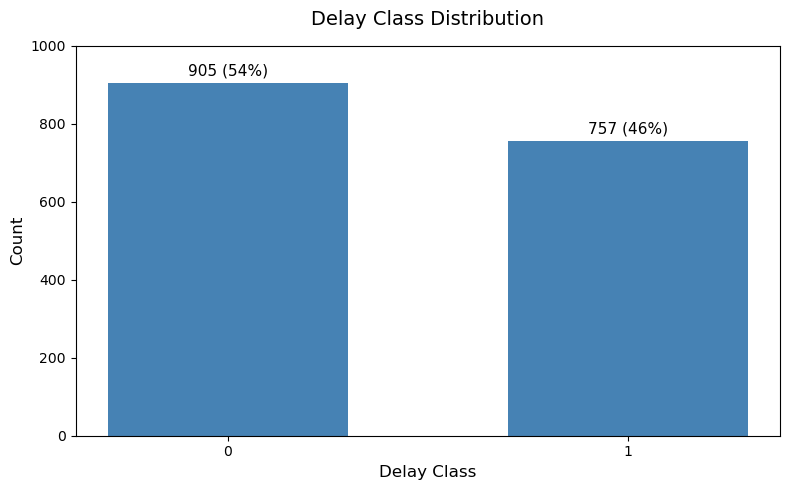

In [9]:
counts = X['delay_class'].value_counts().sort_index()
proportions = X['delay_class'].value_counts(normalize=True).sort_index()

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bar_color = '#4682B4'
bars = ax.bar(counts.index.astype(str), counts.values, color=bar_color, width=0.6)

# Set axis labels and title
ax.set_ylabel("Count", fontsize=12)
ax.set_xlabel("Delay Class", fontsize=12)
ax.set_title("Delay Class Distribution", fontsize=14, pad=15)
ax.set_ylim([0, 1000])

# Add combined labels above bars
for bar, count, prop in zip(bars, counts, proportions):
    label = f"{count} ({int(round(prop * 100))}%)"
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10,
            label, ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

In [10]:
X = X.drop(X.columns[:5], axis=1)
X.head()

,blood_culture_before_antibiotic,urine_culture_before_antibiotic,time_to_culture,has_infectious_disease,has_respiratory_infection,has_pneumonia,has_sepsis,has_urinary_infection,has_cns_infection,has_skin_infection,...,dbp_std,has_low_dbp,reg_hour,reg_shift_Day,reg_shift_Evening,reg_weekday,reg_month,sepsis_x_crp,wbc_crp_interaction,delay_class
0,0,0,-1.000000,0,0,0,0,0,0,0,...,7.333637,1.0,16,0,1,2,3,-0.0,-15.10,0
1,0,0,4587.283333,0,0,0,0,0,0,0,...,12.675838,1.0,1,0,0,1,9,-0.0,-14.58,0
2,1,0,-1.000000,0,0,0,0,0,0,0,...,10.377423,1.0,1,0,0,6,3,0.0,55.00,0
3,0,0,-1.000000,0,0,0,0,0,0,0,...,10.260879,1.0,20,0,1,1,6,-0.0,-12.05,0
4,0,0,8223.583333,0,0,0,0,0,0,0,...,19.897765,1.0,15,0,1,5,8,0.0,427.68,0


## split the dataset to train and test set, normalize dataset

In [12]:
X_features = X.drop(columns=["delay_class"])
y_target = X["delay_class"]
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_target, test_size=0.1, random_state=42, stratify=y_target
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
for i, col in enumerate(X_features.columns, 1):
    print(f"{i}. {col}")

1. blood_culture_before_antibiotic
2. urine_culture_before_antibiotic
3. time_to_culture
4. has_infectious_disease
5. has_respiratory_infection
6. has_pneumonia
7. has_sepsis
8. has_urinary_infection
9. has_cns_infection
10. has_skin_infection
11. any_immuno_before_antibiotic
12. pneumococcal_vaccine_before_antibiotic
13. hib_vaccine_before_antibiotic
14. platelet_latest
15. wbc_mean
16. crp_mean
17. urine_wbc_mean
18. esr_latest
19. anc_mean
20. urine_clarity_mean
21. urine_leukocyte_mean
22. urine_nitrite_mean
23. wbc_high
24. crp_very_high
25. pressor_administered
26. heart_rate_mean
27. heart_rate_std
28. has_tachycardia
29. sbp_mean
30. sbp_std
31. has_hypotension
32. dbp_mean
33. dbp_std
34. has_low_dbp
35. reg_hour
36. reg_shift_Day
37. reg_shift_Evening
38. reg_weekday
39. reg_month
40. sepsis_x_crp
41. wbc_crp_interaction


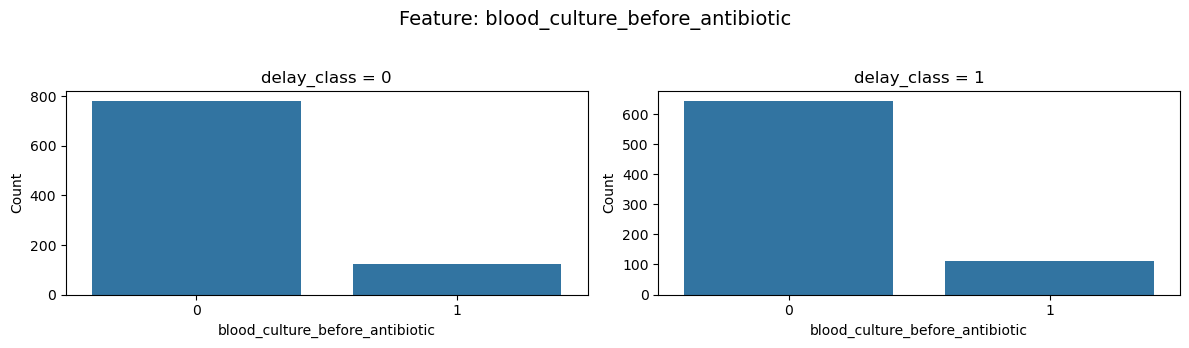

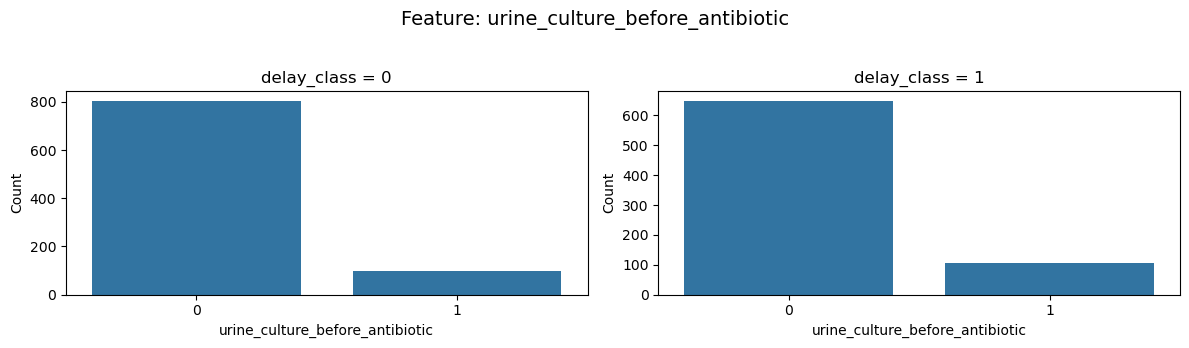

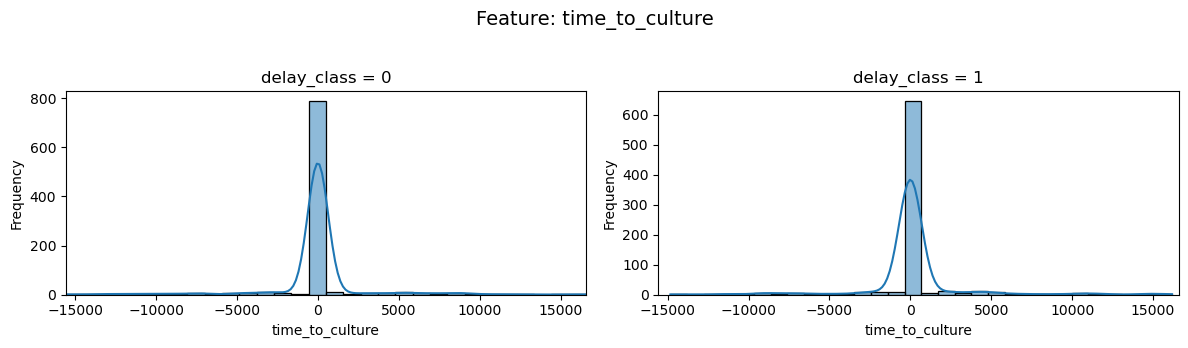

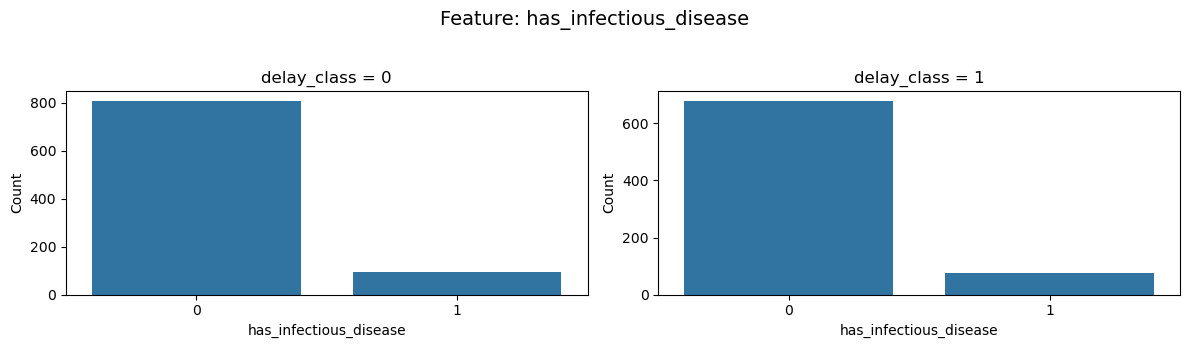

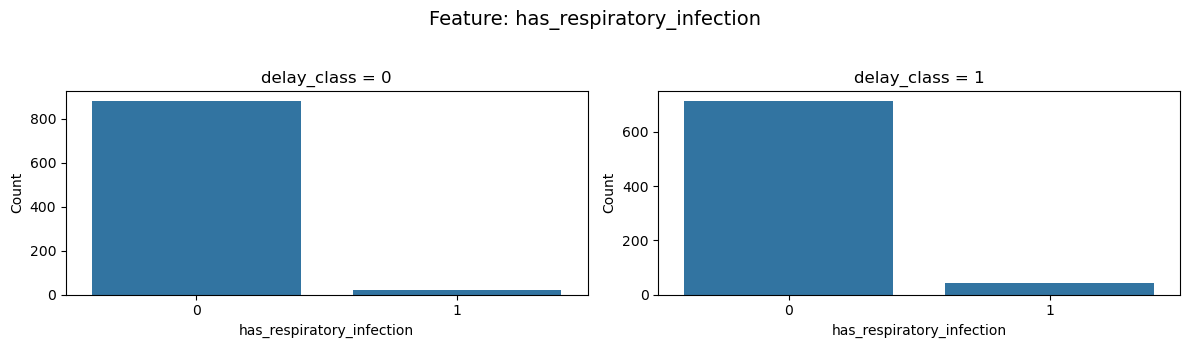

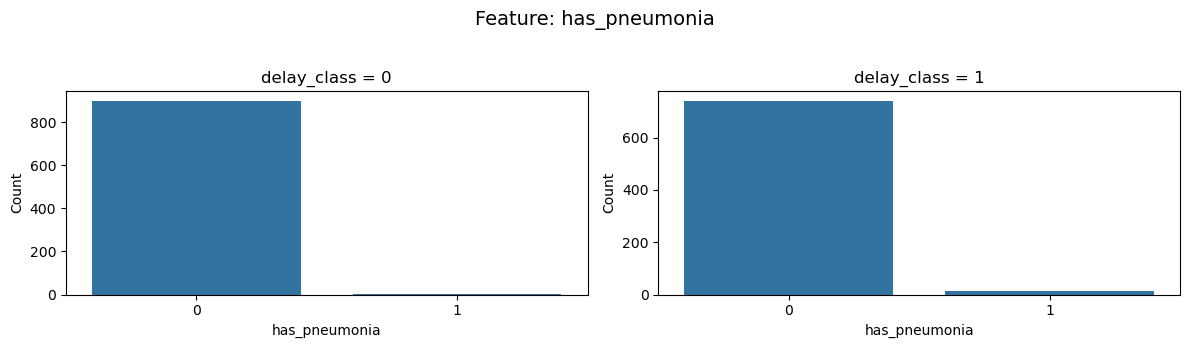

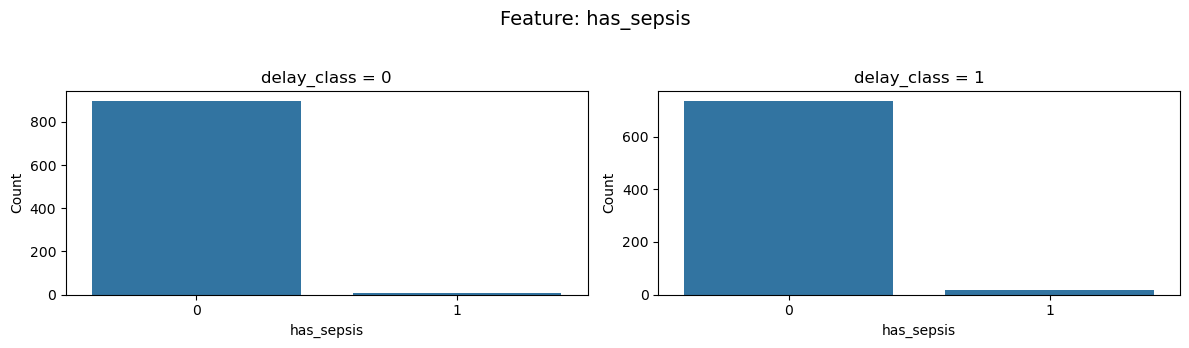

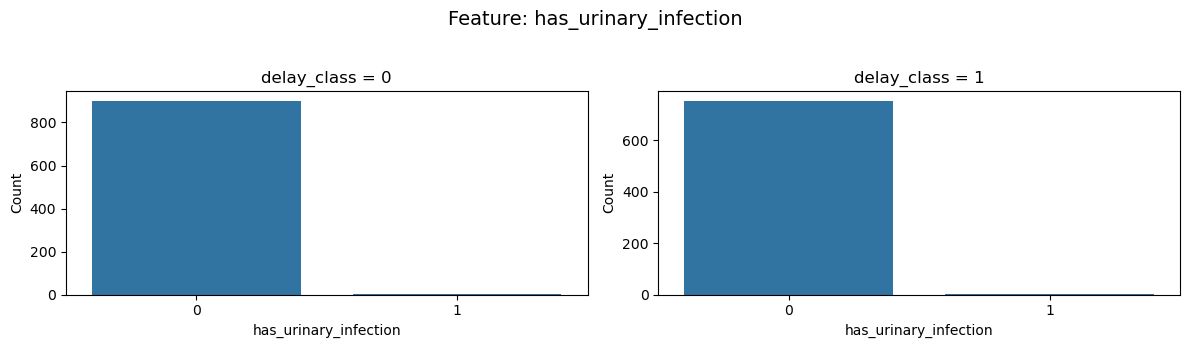

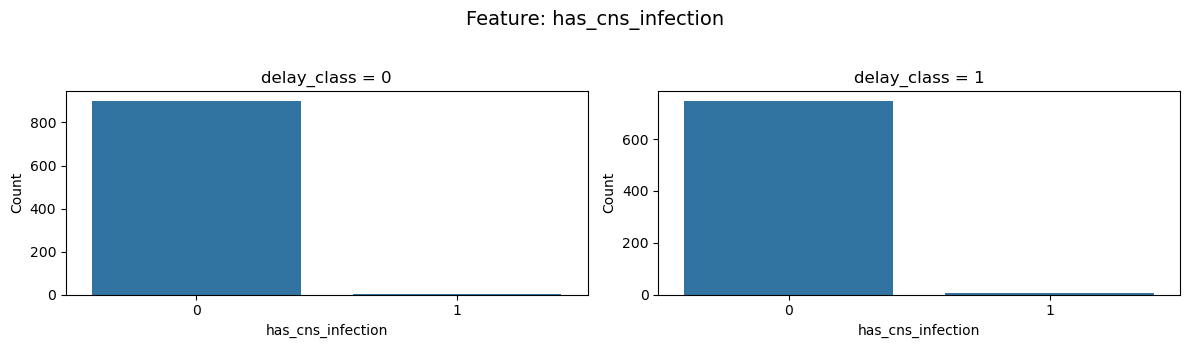

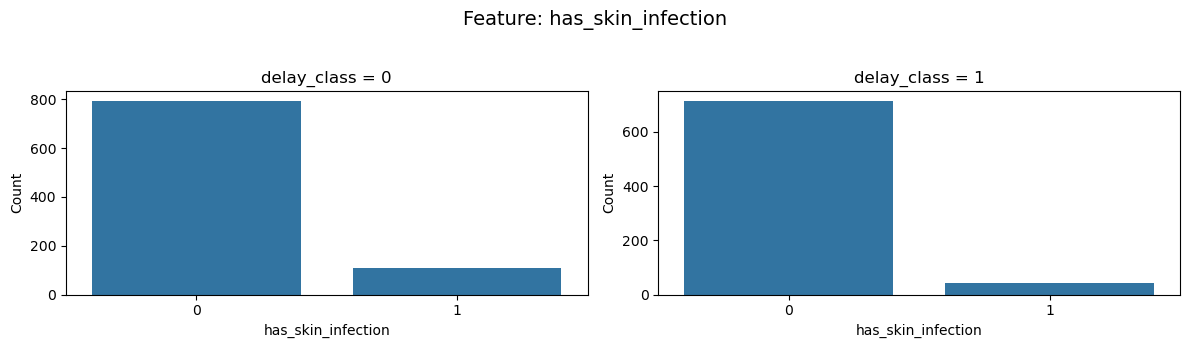

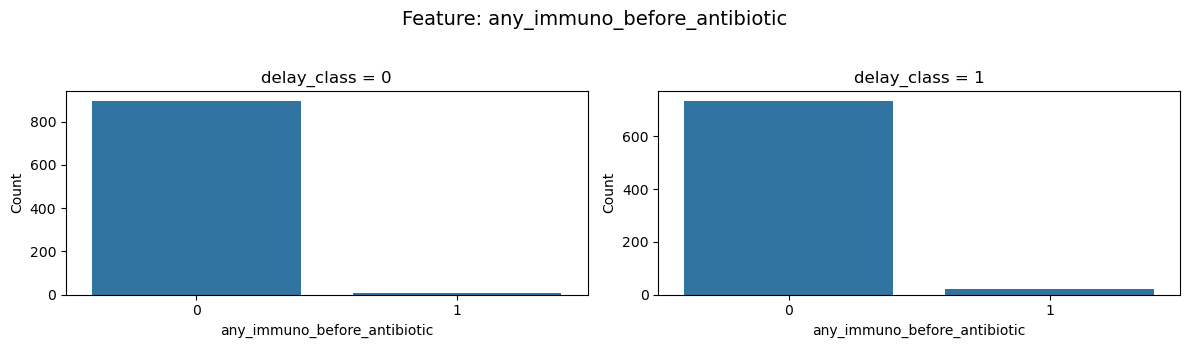

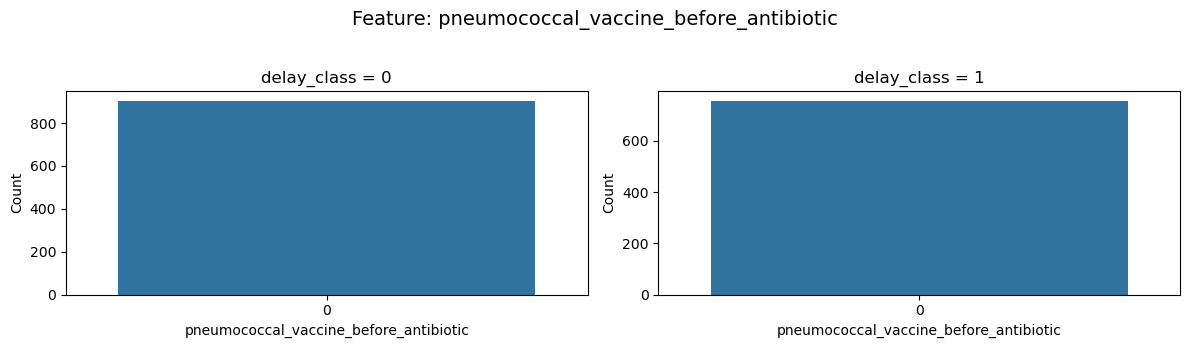

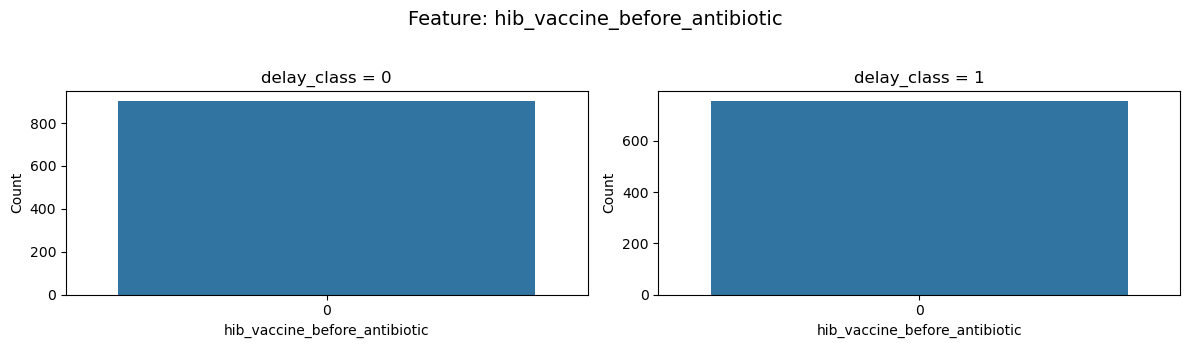

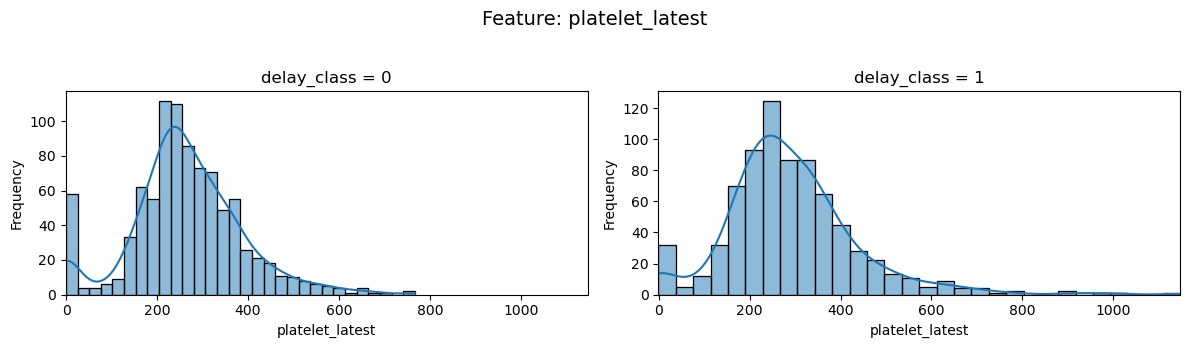

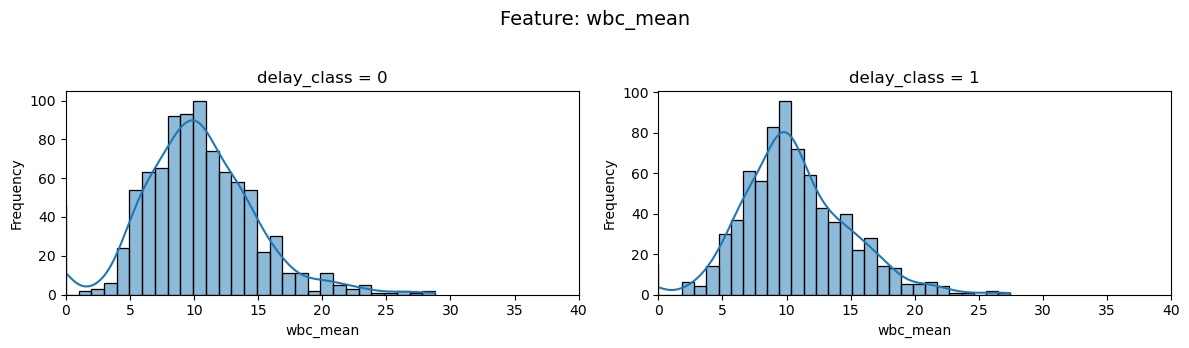

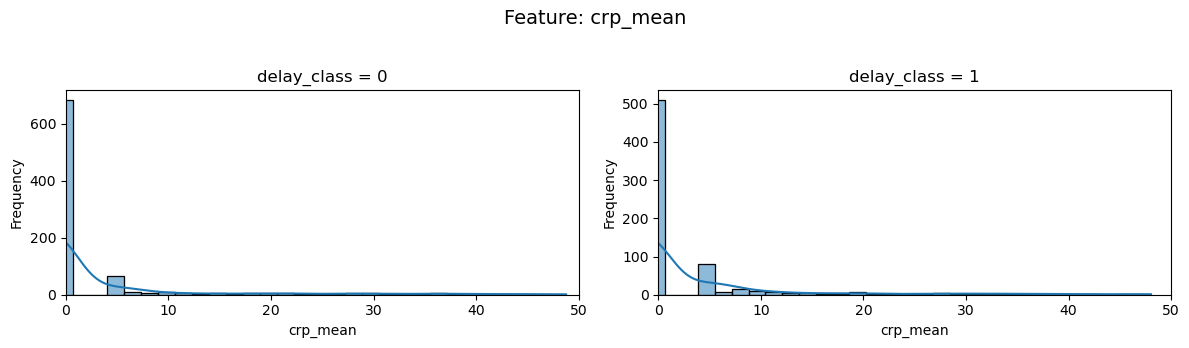

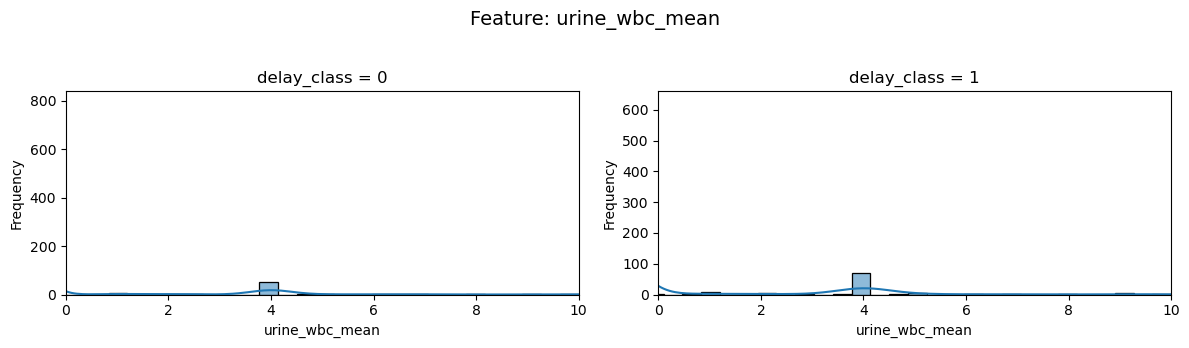

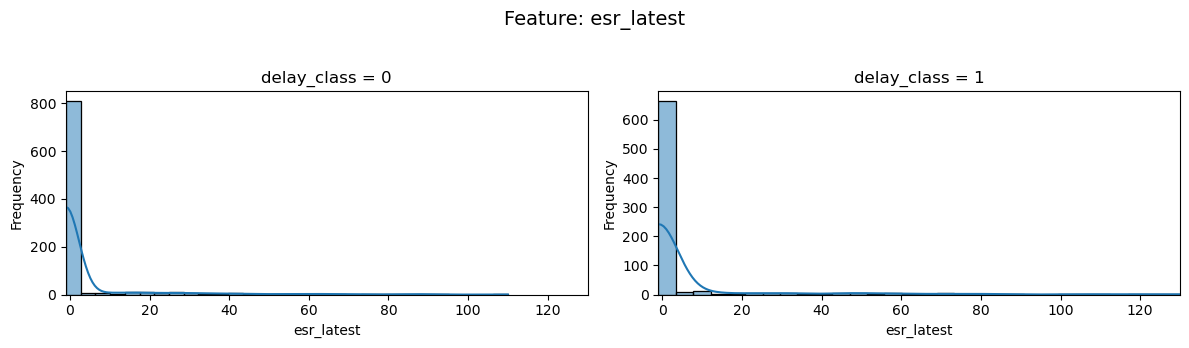

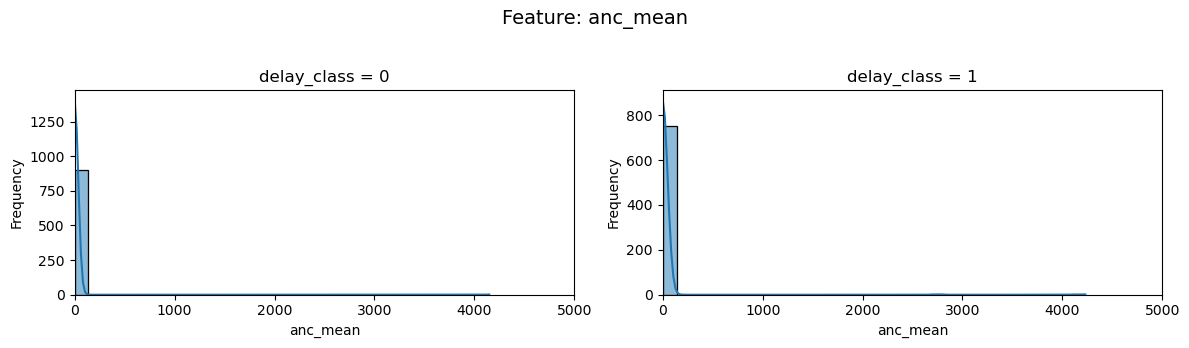

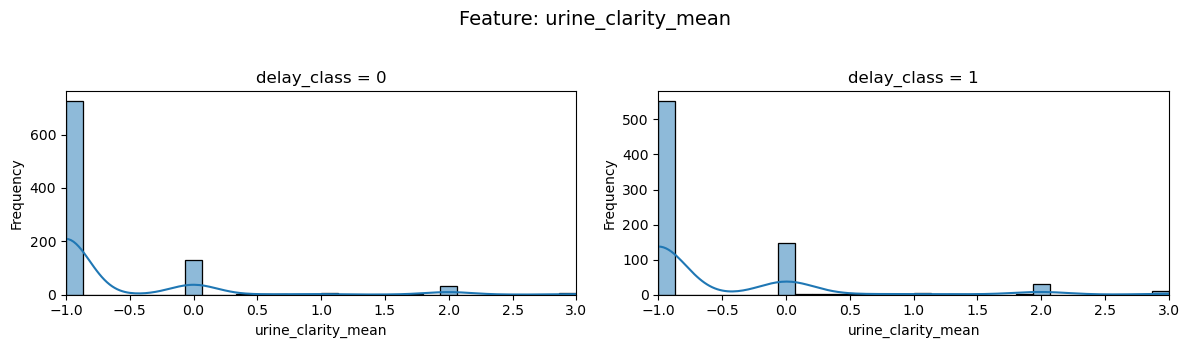

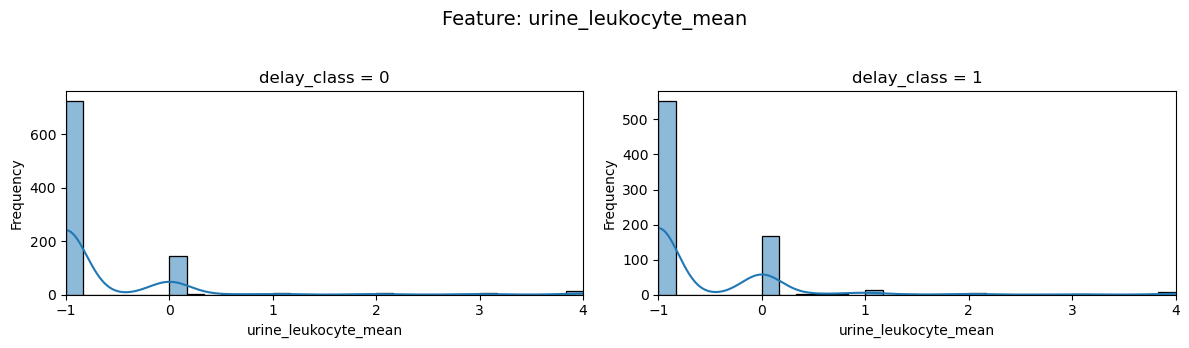

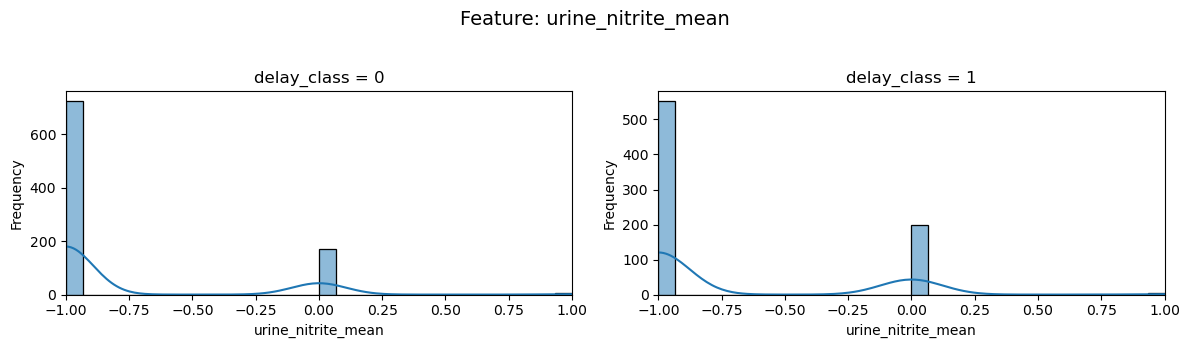

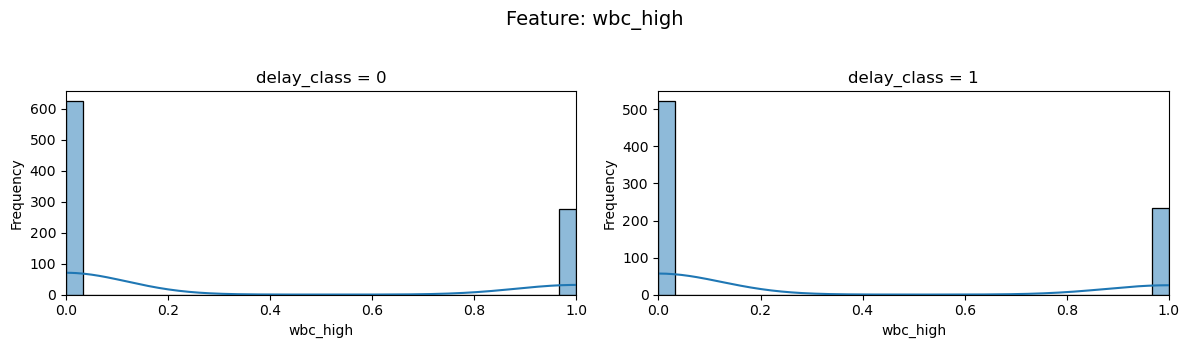

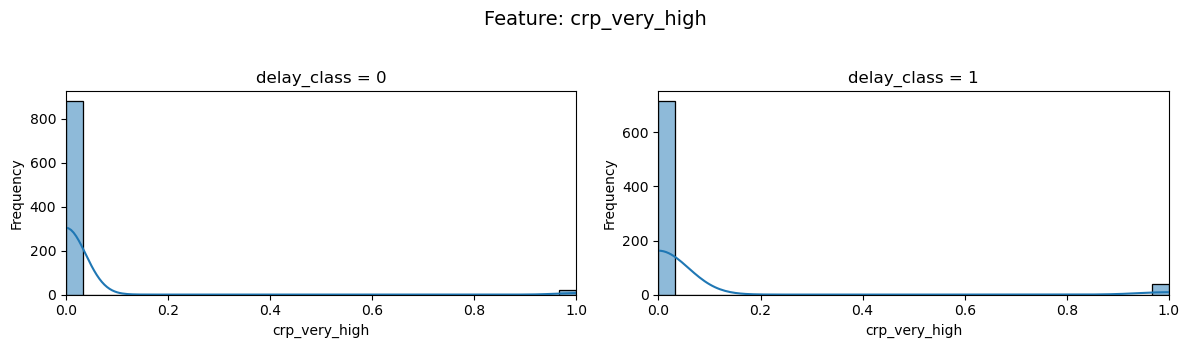

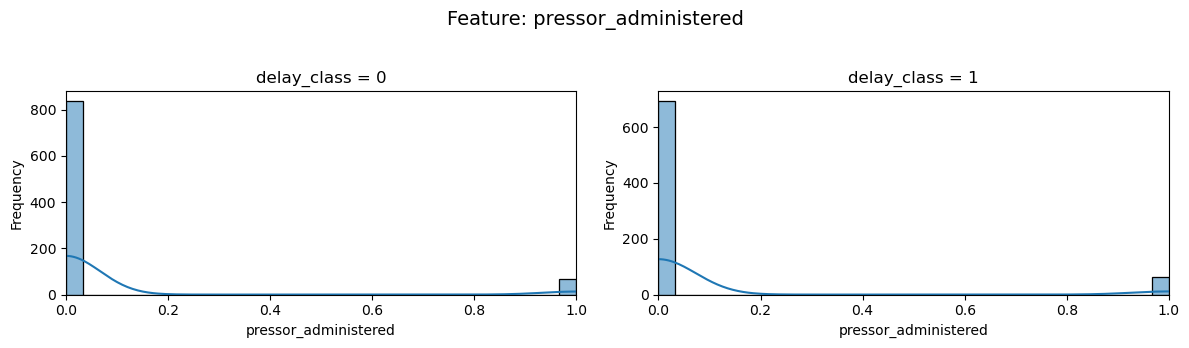

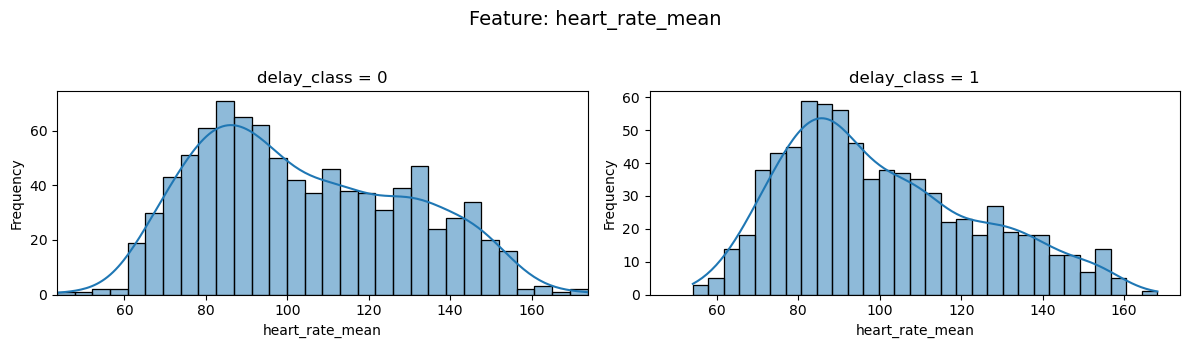

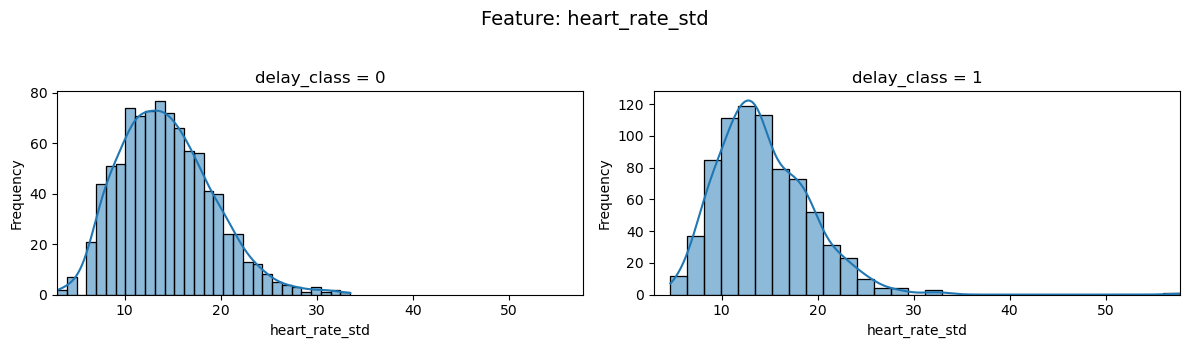

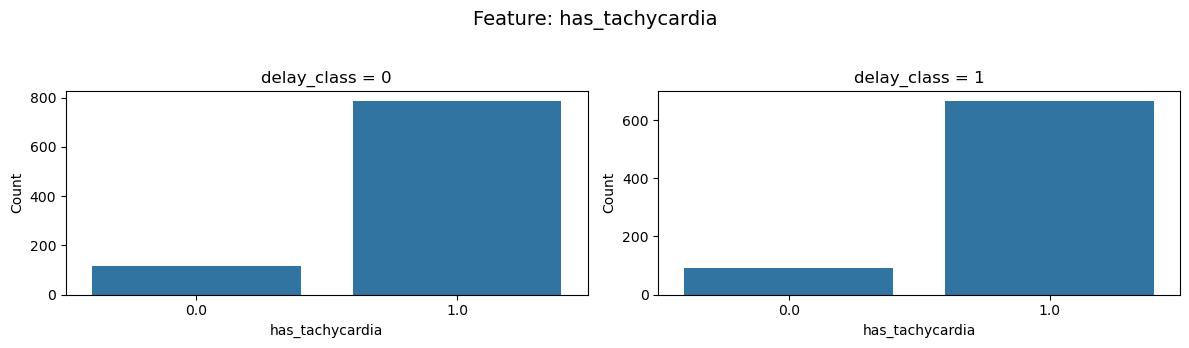

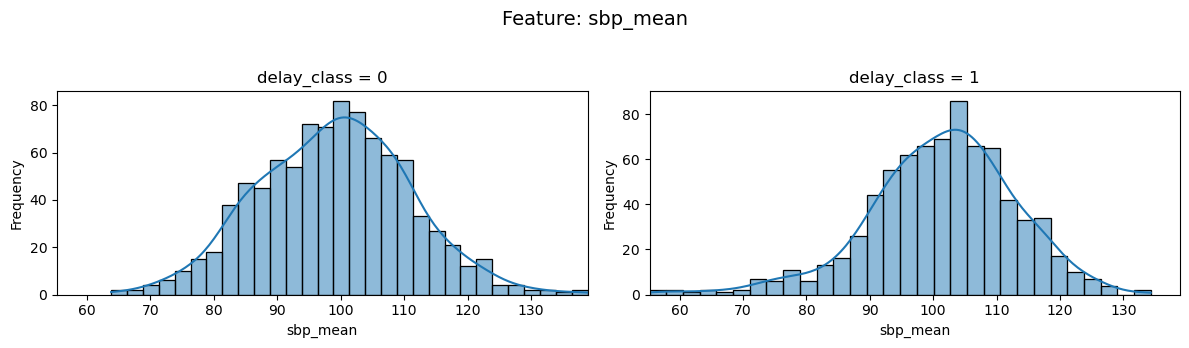

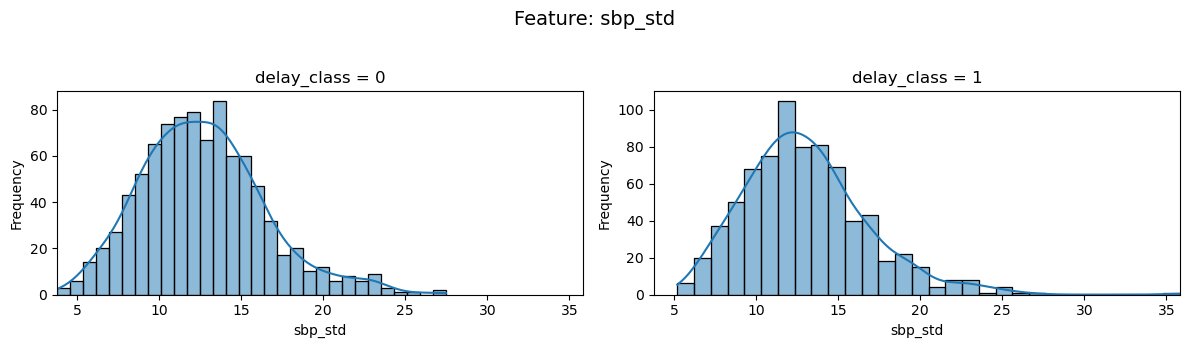

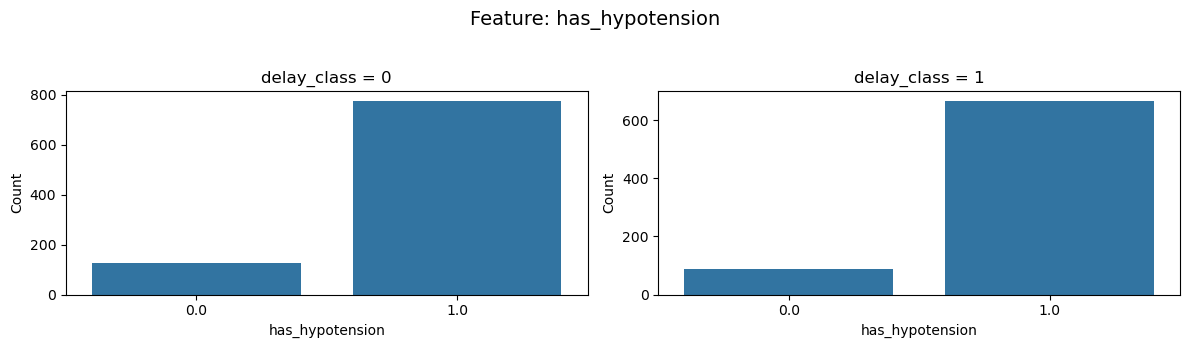

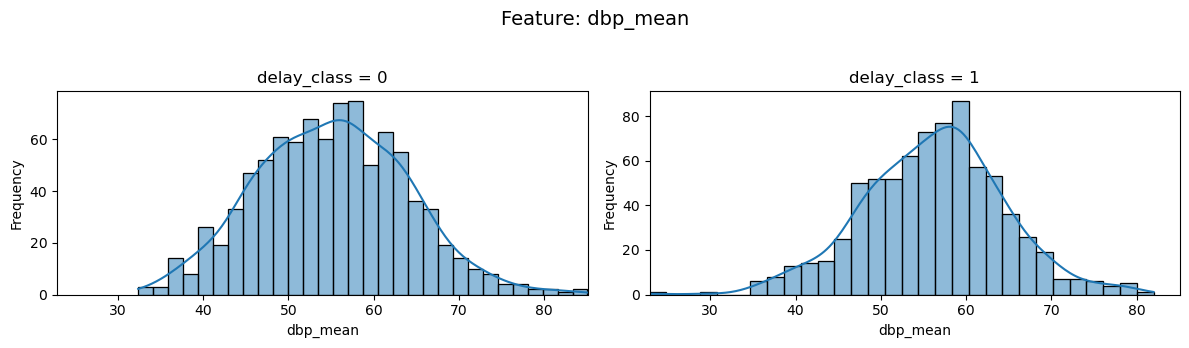

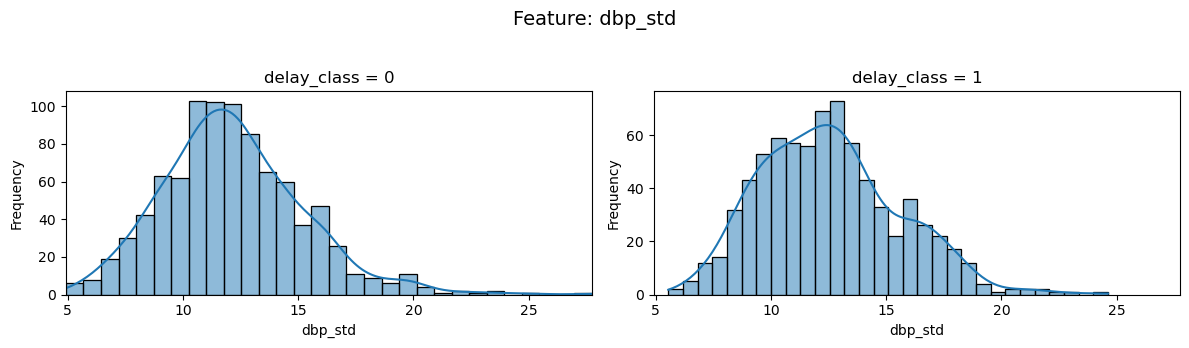

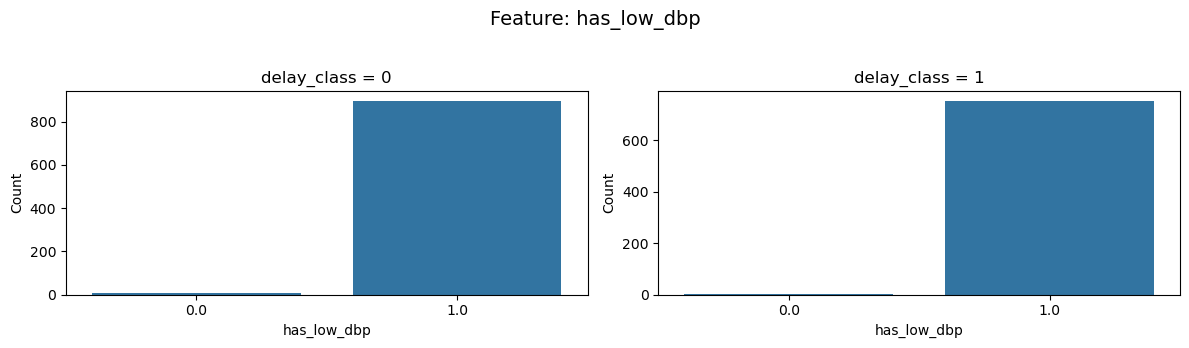

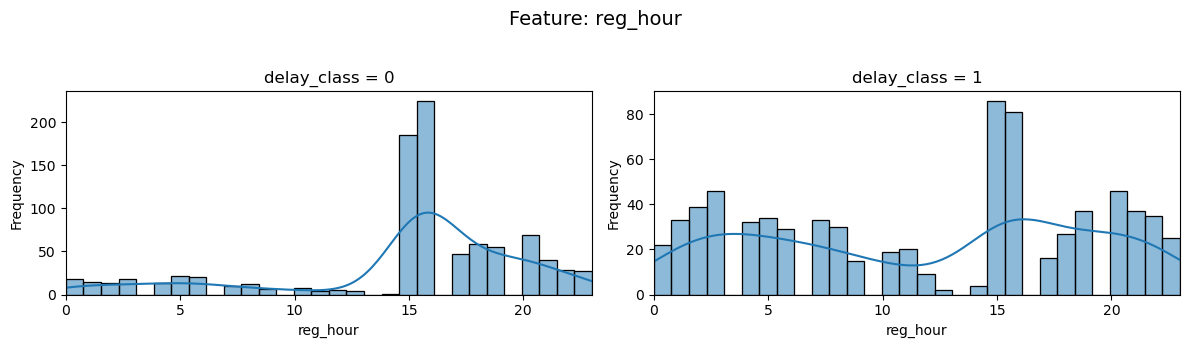

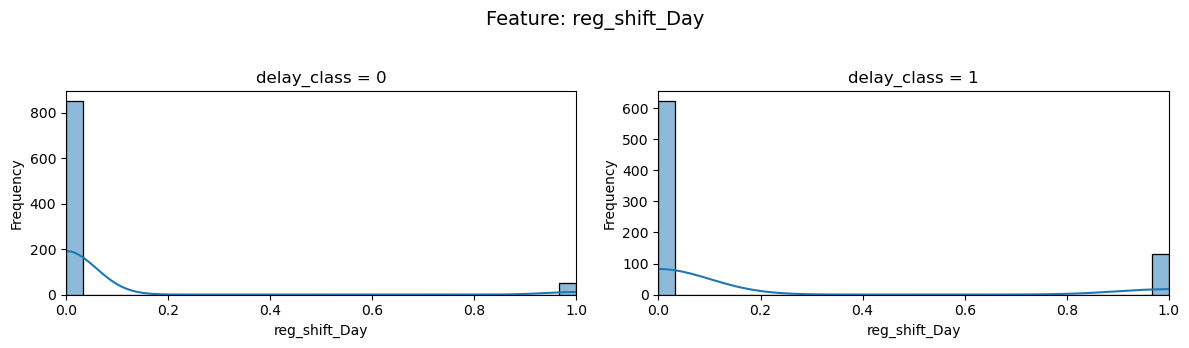

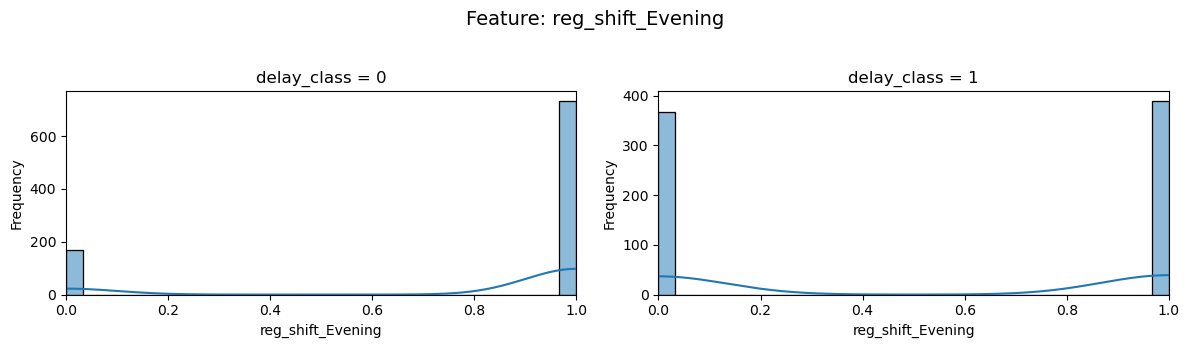

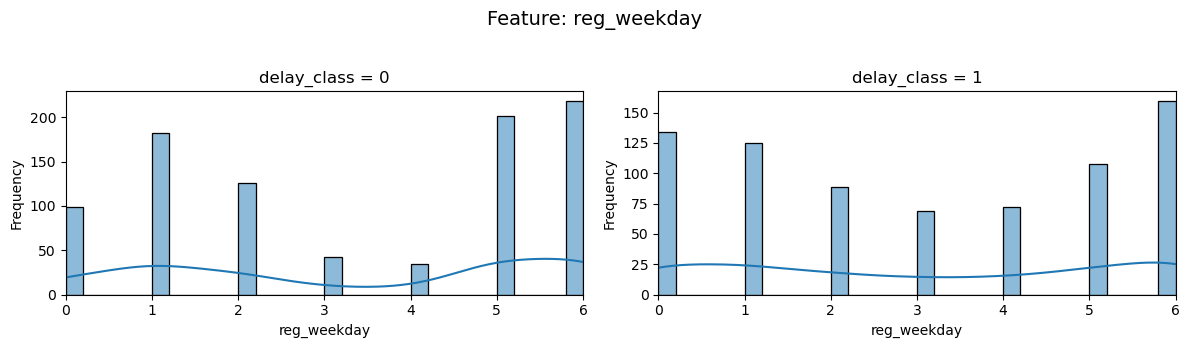

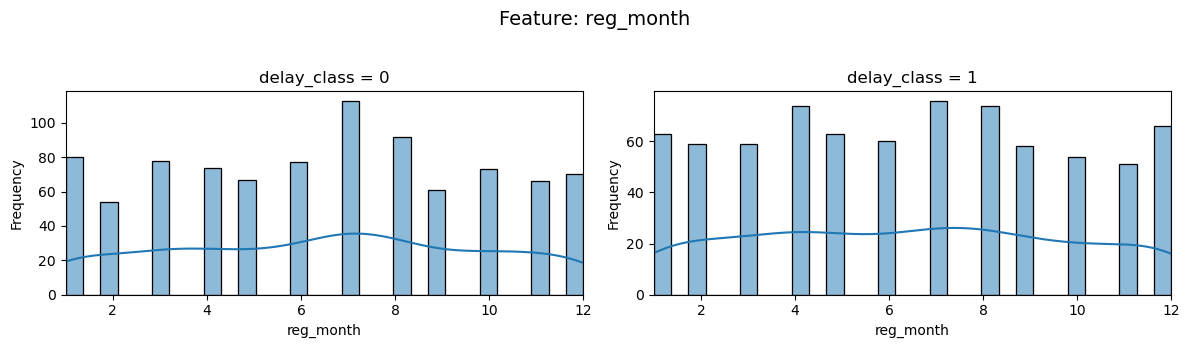

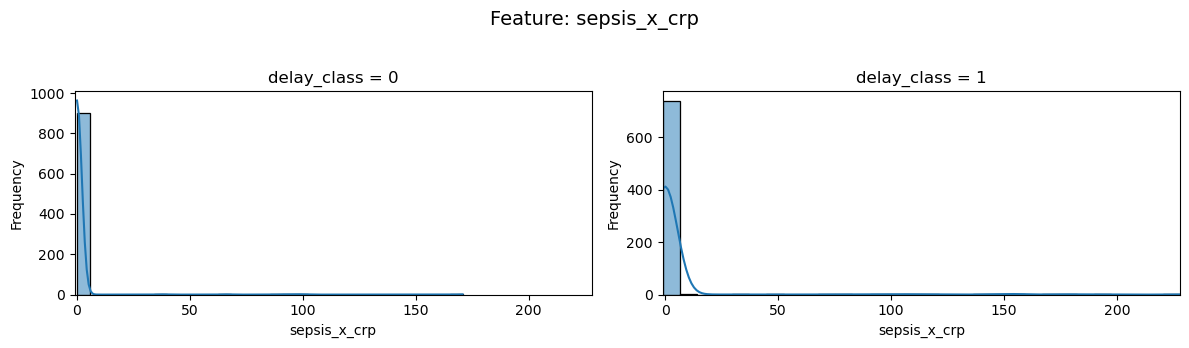

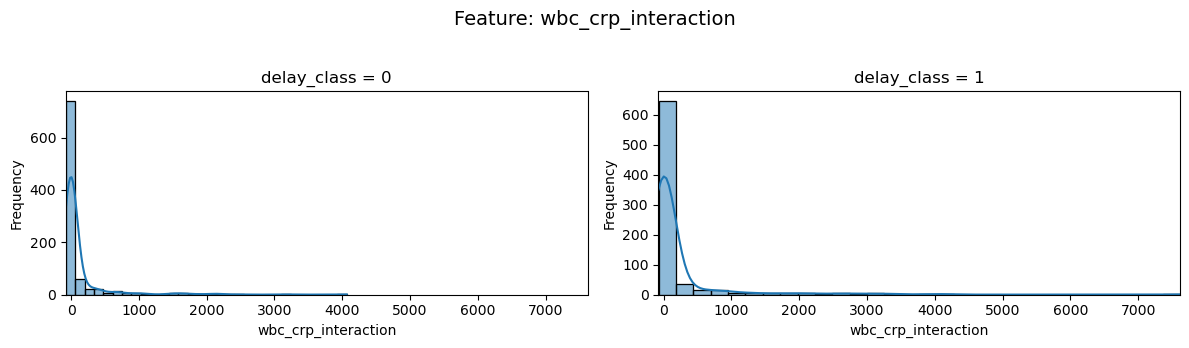

In [14]:
binary_features = [col for col in X_features.columns if col.startswith("has") or "before" in col]
numerical_features = [col for col in X_features.columns if col not in binary_features]

X_with_target = X_features.copy()
X_with_target["delay_class"] = y_target

clip_dict = {
    'wbc_mean': 40,
    'crp_mean': 50,
    'urine_wbc_mean': 10,
    'anc_mean': 5000
}

for col in X_features.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 3.5), sharey=False)
    fig.suptitle(f'Feature: {col}', fontsize=14)

    # Determine consistent x-axis limits
    if col in binary_features:
        xlim = None
    else:
        # Compute min and max across the whole dataset or apply clip
        all_vals = X_with_target[col].dropna()
        if col in clip_dict:
            all_vals = all_vals[all_vals <= clip_dict[col]]
            xlim = (0, clip_dict[col])
        else:
            xlim = (all_vals.min(), all_vals.max())

    for i, cls in enumerate(sorted(X_with_target["delay_class"].unique())):
        subset = X_with_target[X_with_target["delay_class"] == cls]
        ax = axes[i]

        if col in binary_features:
            sns.countplot(data=subset, x=col, ax=ax)
            ax.set_ylabel("Count")
        else:
            plot_data = subset[col].dropna()
            if col in clip_dict:
                plot_data = plot_data[plot_data <= clip_dict[col]]
            sns.histplot(plot_data, kde=True, bins=30, ax=ax)
            ax.set_ylabel("Frequency")
            ax.set_xlim(xlim)  # Apply consistent x-axis limit

        ax.set_title(f'delay_class = {cls}')
        ax.set_xlabel(col)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Model

## Multinomial Regression

In [17]:
lr = LogisticRegression(
    #multi_class='multinomial', 
    class_weight='balanced',
    max_iter=10000                
)

lr.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=10000)

In [18]:
y_pred = lr.predict(X_test)

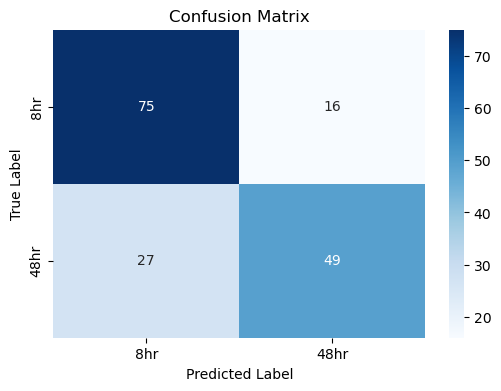

In [19]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            #xticklabels=['6hr', '12hr', '48hr'],
            xticklabels=['8hr', '48hr'],
            #yticklabels=['6hr', '12hr', '48hr'])
            yticklabels=['8hr', '48hr'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [20]:
#print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['6hr', '12hr', '48hr']))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['8hr', '48hr']))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         8hr       0.74      0.82      0.78        91
        48hr       0.75      0.64      0.70        76

    accuracy                           0.74       167
   macro avg       0.74      0.73      0.74       167
weighted avg       0.74      0.74      0.74       167

Accuracy: 0.7425149700598802


In [21]:
y_proba = lr.predict_proba(X_test)[:, 1]  # Only probabilities for the positive class

# Calculate FPR, TPR
fpr_logit, tpr_logit, _ = roc_curve(y_test, y_proba)
auc_logit = roc_auc_score(y_test, y_proba)

In [22]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_features.columns
vif_data["VIF"] = [variance_inflation_factor(X_features.values, i) for i in range(X_features.shape[1])]
print(vif_data.sort_values("VIF", ascending=False))

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                                   feature         VIF
28                                sbp_mean  185.537075
31                                dbp_mean  106.956652
33                             has_low_dbp  102.383155
34                                reg_hour   46.156724
36                       reg_shift_Evening   36.629698
25                         heart_rate_mean   32.210041
32                                 dbp_std   31.014907
29                                 sbp_std   22.297431
21                      urine_nitrite_mean   20.287625
26                          heart_rate_std   13.614437
15                                crp_mean   11.745675
27                         has_tachycardia   11.613158
14                                wbc_mean   11.444005
30                         has_hypotension   10.671039
40                     wbc_crp_interaction    8.438519
13                         platelet_latest    7.193970
20                    urine_leukocyte_mean    6.408403
19        

/var/folders/vz/tk38nmzj5xd05b2t1bmzsy2h0000gn/T/ipykernel_87853/290143860.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


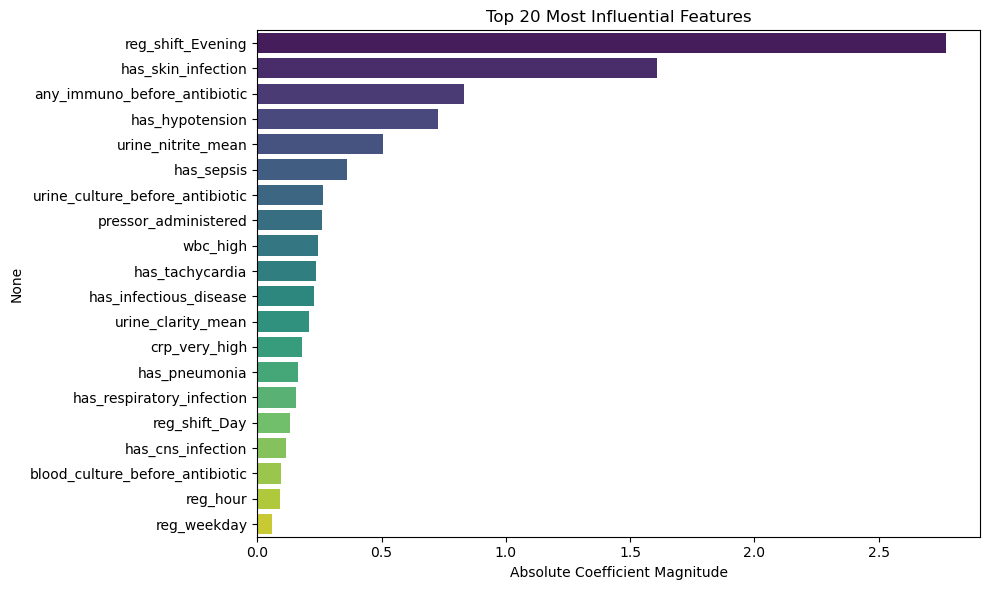

In [23]:
coefs = pd.Series(np.abs(lr.coef_[0]), index=X_features.columns)
top_features = coefs.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.xlabel("Absolute Coefficient Magnitude")
plt.title("Top 20 Most Influential Features")
plt.tight_layout()
plt.show()

/var/folders/vz/tk38nmzj5xd05b2t1bmzsy2h0000gn/T/ipykernel_87853/2173447050.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_plot.groupby('bin').agg({col: 'mean', 'prob': 'mean'}).dropna()
/var/folders/vz/tk38nmzj5xd05b2t1bmzsy2h0000gn/T/ipykernel_87853/2173447050.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_plot.groupby('bin').agg({col: 'mean', 'prob': 'mean'}).dropna()
/var/folders/vz/tk38nmzj5xd05b2t1bmzsy2h0000gn/T/ipykernel_87853/2173447050.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

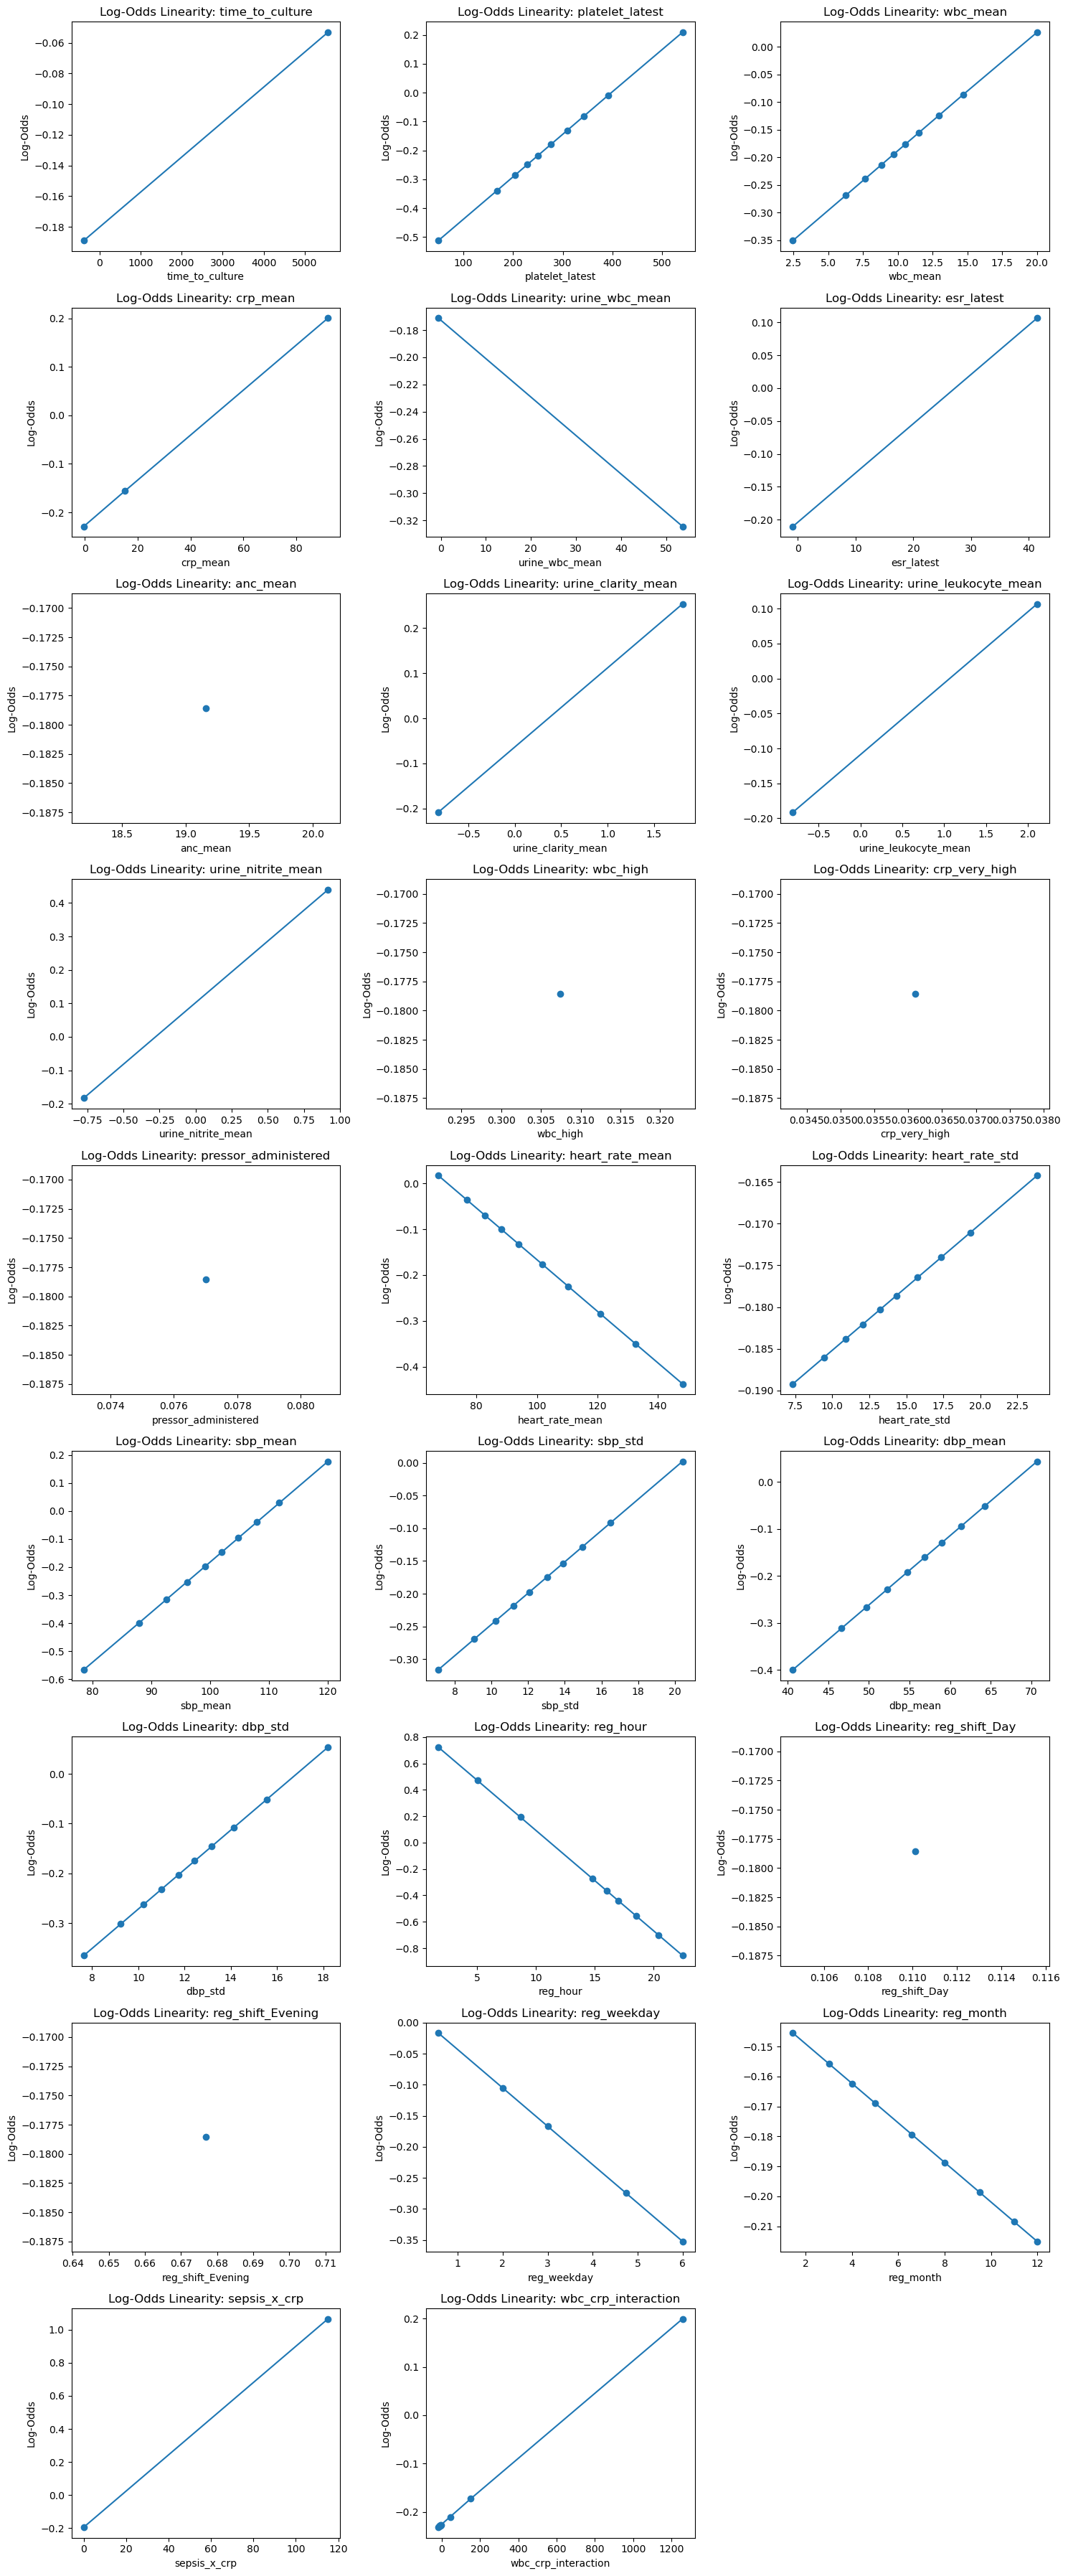

In [24]:
n_cols = 3
n_rows = int(np.ceil(len(numerical_features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    X_temp = sm.add_constant(X_features[col])
    model = sm.Logit(y_target, X_temp).fit(disp=0)
    probs = model.predict(X_temp)

    # Bin the predictor into quantiles
    df_plot = pd.DataFrame({
        col: X_features[col],
        'prob': probs
    })
    df_plot['bin'] = pd.qcut(df_plot[col], q=10, duplicates='drop')
    grouped = df_plot.groupby('bin').agg({col: 'mean', 'prob': 'mean'}).dropna()
    grouped['log_odds'] = np.log(grouped['prob'] / (1 - grouped['prob']))

    # Plot
    ax = axes[i]
    ax.plot(grouped[col], grouped['log_odds'], marker='o')
    ax.set_title(f'Log-Odds Linearity: {col}')
    ax.set_xlabel(col)
    ax.set_ylabel("Log-Odds")

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Random Forest

In [26]:
rf = RandomForestClassifier(n_estimators=500, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=500,
                       random_state=42)

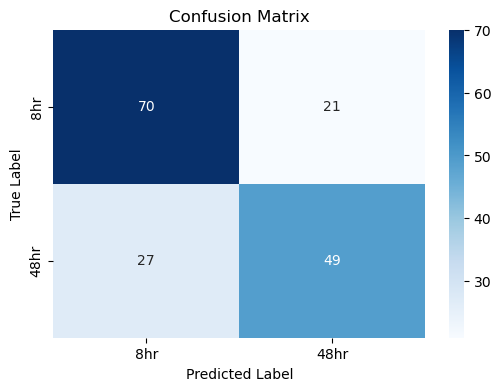

In [27]:
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues',
            #xticklabels = ['6hr', '12hr', '48hr'],
            xticklabels = ['8hr', '48hr'],
            #yticklabels = ['6hr', '12hr', '48hr'])
            yticklabels = ['8hr', '48hr'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [28]:
#print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['6hr', '12hr', '48hr']))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['8hr', '48hr']))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         8hr       0.72      0.77      0.74        91
        48hr       0.70      0.64      0.67        76

    accuracy                           0.71       167
   macro avg       0.71      0.71      0.71       167
weighted avg       0.71      0.71      0.71       167

Accuracy: 0.7125748502994012


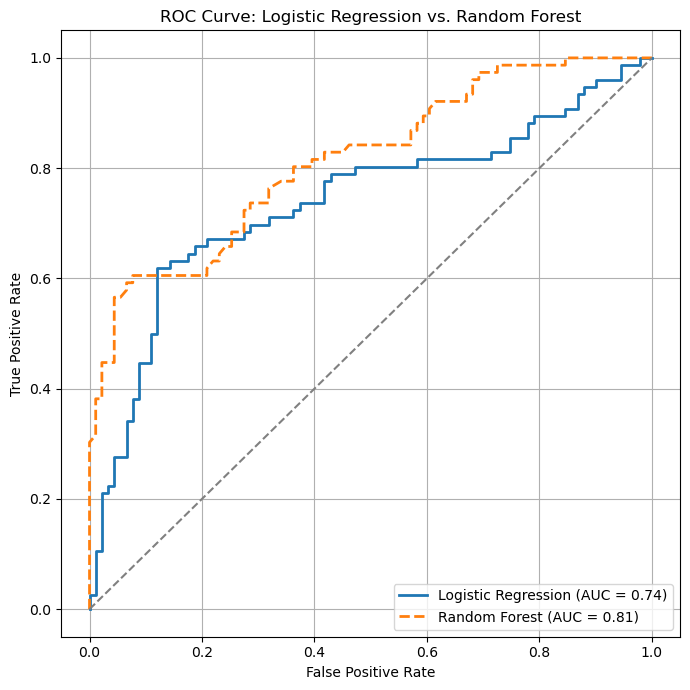

In [29]:
rf_proba = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
auc_rf = roc_auc_score(y_test, rf_proba)

plt.figure(figsize=(7, 7))
plt.plot(fpr_logit, tpr_logit, label=f"Logistic Regression (AUC = {auc_logit:.2f})", linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", linewidth=2, linestyle="--")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Logistic Regression vs. Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
importances = rf.feature_importances_
feature_names = X_features.columns

# Create a DataFrame for sorting and display
rf_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort by importance descending
rf_importance_df = rf_importance_df.sort_values(by='importance', ascending=False)

# Display top 10
print(rf_importance_df.head(10))

                feature  importance
34             reg_hour    0.084628
28             sbp_mean    0.078192
31             dbp_mean    0.072237
32              dbp_std    0.070362
25      heart_rate_mean    0.067917
29              sbp_std    0.067614
13      platelet_latest    0.064480
26       heart_rate_std    0.064299
40  wbc_crp_interaction    0.063296
14             wbc_mean    0.061292


/var/folders/vz/tk38nmzj5xd05b2t1bmzsy2h0000gn/T/ipykernel_87853/1590828071.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_importance_df.head(10), x='importance', y='feature', palette='crest')


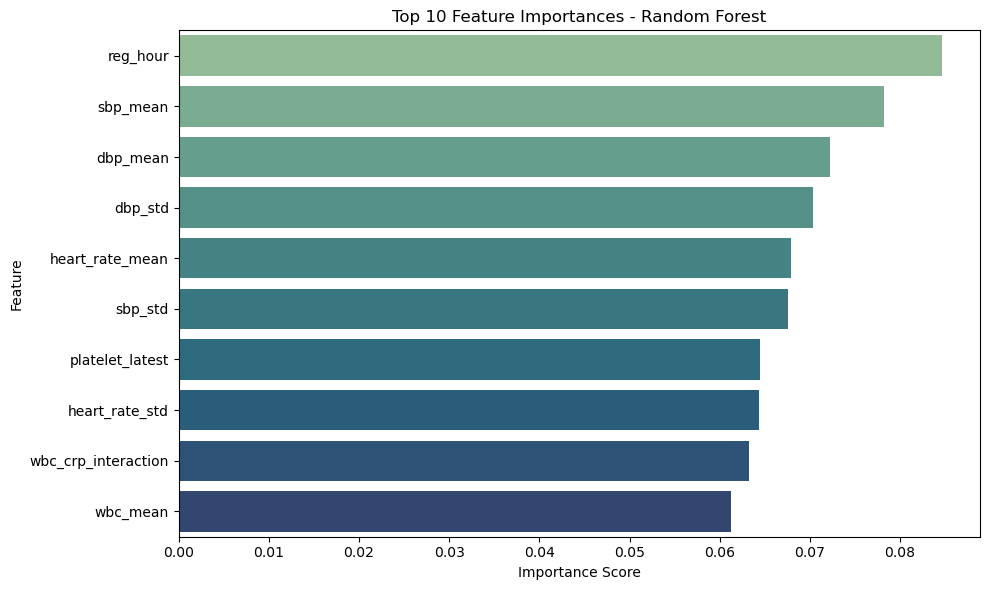

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(data=rf_importance_df.head(10), x='importance', y='feature', palette='crest')
plt.title('Top 10 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [32]:
class AbxDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [33]:
train_dataset = AbxDataset(X_train, y_train)
test_dataset = AbxDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [34]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedforwardNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [35]:
model = FeedforwardNN(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [36]:
for epoch in range(1000):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Loss: 0.6905
Epoch 2, Loss: 0.6873
Epoch 3, Loss: 0.6818
Epoch 4, Loss: 0.6796
Epoch 5, Loss: 0.6725
Epoch 6, Loss: 0.6649
Epoch 7, Loss: 0.6603
Epoch 8, Loss: 0.6569
Epoch 9, Loss: 0.6521
Epoch 10, Loss: 0.6471
Epoch 11, Loss: 0.6488
Epoch 12, Loss: 0.6448
Epoch 13, Loss: 0.6438
Epoch 14, Loss: 0.6391
Epoch 15, Loss: 0.6386
Epoch 16, Loss: 0.6360
Epoch 17, Loss: 0.6386
Epoch 18, Loss: 0.6426
Epoch 19, Loss: 0.6349
Epoch 20, Loss: 0.6341
Epoch 21, Loss: 0.6348
Epoch 22, Loss: 0.6364
Epoch 23, Loss: 0.6357
Epoch 24, Loss: 0.6309
Epoch 25, Loss: 0.6318
Epoch 26, Loss: 0.6325
Epoch 27, Loss: 0.6290
Epoch 28, Loss: 0.6230
Epoch 29, Loss: 0.6385
Epoch 30, Loss: 0.6246
Epoch 31, Loss: 0.6261
Epoch 32, Loss: 0.6248
Epoch 33, Loss: 0.6219
Epoch 34, Loss: 0.6267
Epoch 35, Loss: 0.6242
Epoch 36, Loss: 0.6160
Epoch 37, Loss: 0.6183
Epoch 38, Loss: 0.6215
Epoch 39, Loss: 0.6173
Epoch 40, Loss: 0.6189
Epoch 41, Loss: 0.6163
Epoch 42, Loss: 0.6124
Epoch 43, Loss: 0.6186
Epoch 44, Loss: 0.61

In [37]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        output = model(X_batch)
        preds = (output.cpu() > 0.5).float()
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

print(confusion_matrix(all_labels, all_preds))
print(classification_report(all_labels, all_preds))

[[63 28]
 [30 46]]
              precision    recall  f1-score   support

         0.0       0.68      0.69      0.68        91
         1.0       0.62      0.61      0.61        76

    accuracy                           0.65       167
   macro avg       0.65      0.65      0.65       167
weighted avg       0.65      0.65      0.65       167



In [38]:
nn_proba = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        output = model(X_batch)
        nn_proba.extend(output.cpu().numpy().flatten()) 
    
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_proba)
auc_nn = roc_auc_score(y_test, nn_proba)

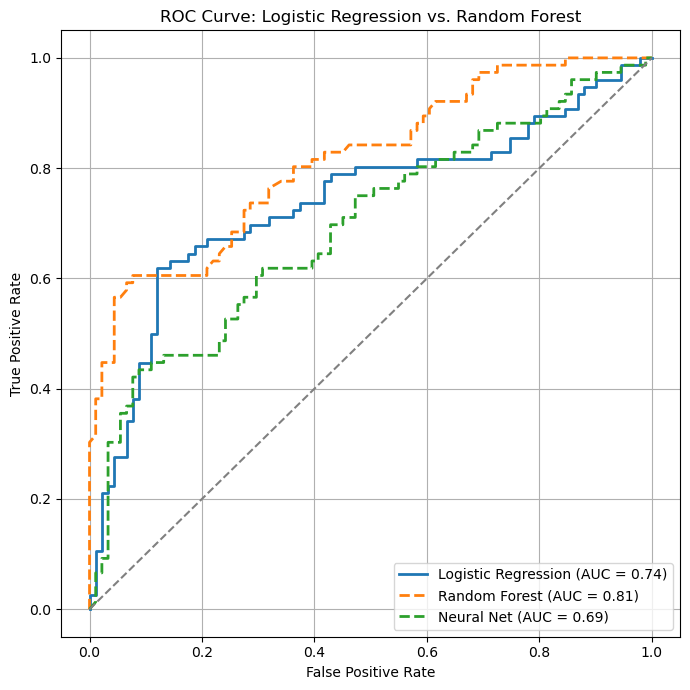

In [39]:
plt.figure(figsize=(7, 7))
plt.plot(fpr_logit, tpr_logit, label=f"Logistic Regression (AUC = {auc_logit:.2f})", linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", linewidth=2, linestyle="--")
plt.plot(fpr_nn, tpr_nn, label=f"Neural Net (AUC = {auc_nn:.2f})", linewidth=2, linestyle="--")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Logistic Regression vs. Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Optimal threshold for accuracy: 0.590 (Accuracy: 0.778)
Optimal threshold for F1-score: 0.440 (F1-score: 0.712)


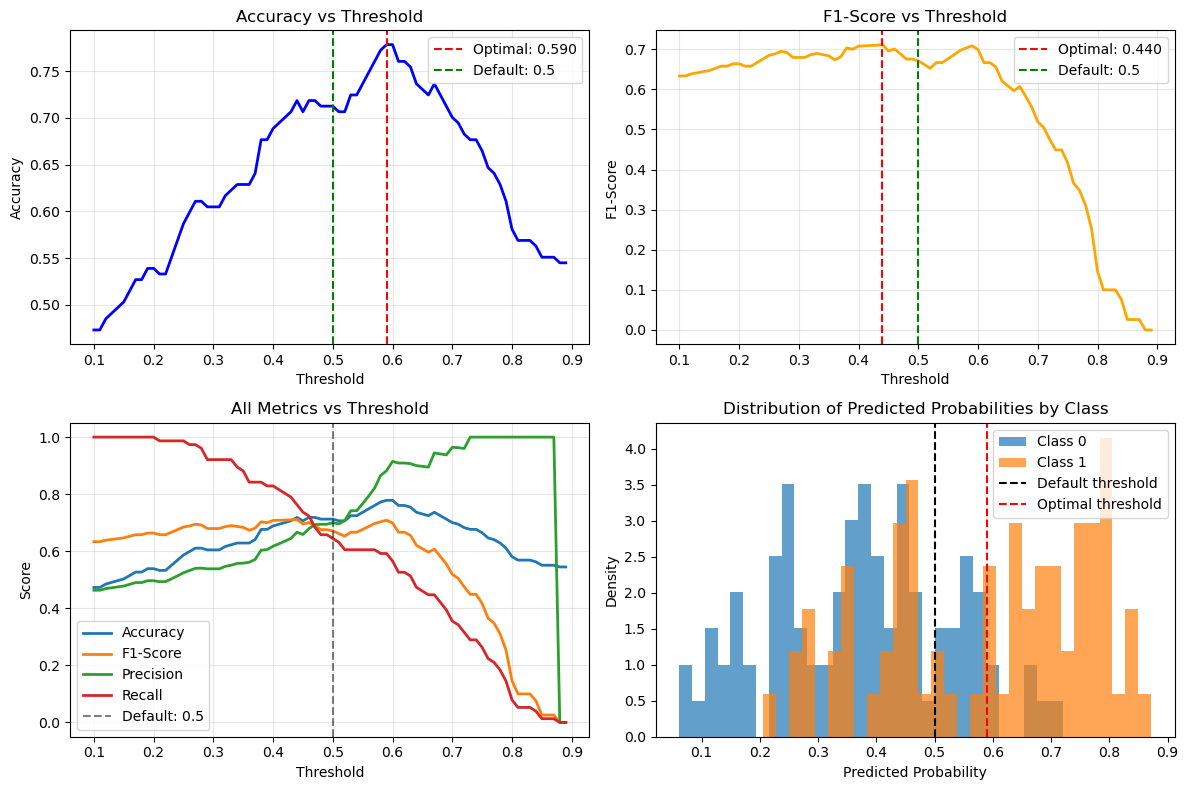


Performance Comparison at Different Thresholds:
   threshold  accuracy  precision  recall  f1_score
0       0.30    0.6048     0.5385  0.9211    0.6796
1       0.40    0.6886     0.6176  0.8289    0.7079
2       0.50    0.7126     0.7000  0.6447    0.6712
3       0.59    0.7784     0.8824  0.5921    0.7087
4       0.44    0.7186     0.6667  0.7632    0.7117
5       0.60    0.7784     0.9149  0.5658    0.6992
6       0.70    0.7006     0.9643  0.3553    0.5192


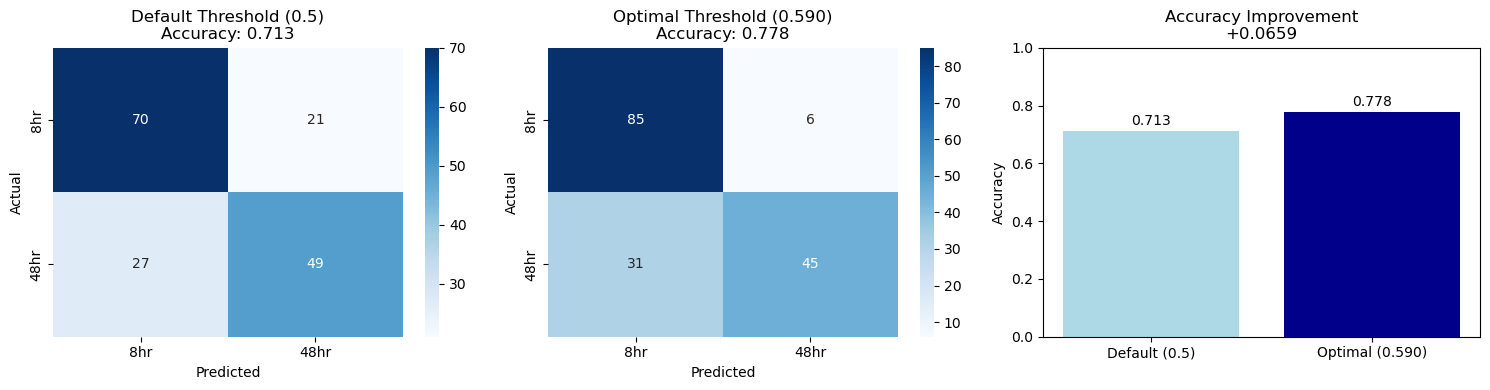


Classification Report - Default Threshold (0.5):
              precision    recall  f1-score   support

         8hr       0.72      0.77      0.74        91
        48hr       0.70      0.64      0.67        76

    accuracy                           0.71       167
   macro avg       0.71      0.71      0.71       167
weighted avg       0.71      0.71      0.71       167


Classification Report - Optimal Threshold (0.590):
              precision    recall  f1-score   support

         8hr       0.73      0.93      0.82        91
        48hr       0.88      0.59      0.71        76

    accuracy                           0.78       167
   macro avg       0.81      0.76      0.76       167
weighted avg       0.80      0.78      0.77       167


Accuracy Improvement: 0.0659 (6.59%)


In [40]:
# Random Forest Threshold Optimization for Higher Accuracy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Assuming your Random Forest model (rf) and test data are already available
# rf_proba = rf.predict_proba(X_test)[:, 1]  # This should already be computed from your existing code

def find_optimal_threshold(y_true, y_proba, metric='accuracy'):
    """
    Find optimal threshold for binary classification based on specified metric
    """
    thresholds = np.arange(0.1, 0.9, 0.01)
    scores = []
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        
        if metric == 'accuracy':
            score = accuracy_score(y_true, y_pred)
        elif metric == 'f1':
            score = f1_score(y_true, y_pred)
        elif metric == 'precision':
            score = precision_score(y_true, y_pred, zero_division=0)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred)
        
        scores.append(score)
    
    optimal_idx = np.argmax(scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_score = scores[optimal_idx]
    
    return optimal_threshold, optimal_score, thresholds, scores

def evaluate_threshold_performance(y_true, y_proba, thresholds_to_test):
    """
    Evaluate model performance at different thresholds
    """
    results = []
    
    for threshold in thresholds_to_test:
        y_pred = (y_proba >= threshold).astype(int)
        
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        
        results.append({
            'threshold': threshold,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    
    return pd.DataFrame(results)

# Get Random Forest probabilities (this should already be computed in your code)
rf_proba = rf.predict_proba(X_test)[:, 1]

# Find optimal thresholds for different metrics
optimal_acc_threshold, optimal_acc_score, thresholds, acc_scores = find_optimal_threshold(y_test, rf_proba, 'accuracy')
optimal_f1_threshold, optimal_f1_score, _, f1_scores = find_optimal_threshold(y_test, rf_proba, 'f1')

print(f"Optimal threshold for accuracy: {optimal_acc_threshold:.3f} (Accuracy: {optimal_acc_score:.3f})")
print(f"Optimal threshold for F1-score: {optimal_f1_threshold:.3f} (F1-score: {optimal_f1_score:.3f})")

# Plot threshold vs metrics
plt.figure(figsize=(12, 8))

# Plot 1: Accuracy vs Threshold
plt.subplot(2, 2, 1)
plt.plot(thresholds, acc_scores, 'b-', linewidth=2)
plt.axvline(x=optimal_acc_threshold, color='r', linestyle='--', label=f'Optimal: {optimal_acc_threshold:.3f}')
plt.axvline(x=0.5, color='g', linestyle='--', label='Default: 0.5')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: F1-score vs Threshold
plt.subplot(2, 2, 2)
plt.plot(thresholds, f1_scores, 'orange', linewidth=2)
plt.axvline(x=optimal_f1_threshold, color='r', linestyle='--', label=f'Optimal: {optimal_f1_threshold:.3f}')
plt.axvline(x=0.5, color='g', linestyle='--', label='Default: 0.5')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: All metrics together
plt.subplot(2, 2, 3)
_, _, _, precision_scores = find_optimal_threshold(y_test, rf_proba, 'precision')
_, _, _, recall_scores = find_optimal_threshold(y_test, rf_proba, 'recall')

plt.plot(thresholds, acc_scores, label='Accuracy', linewidth=2)
plt.plot(thresholds, f1_scores, label='F1-Score', linewidth=2)
plt.plot(thresholds, precision_scores, label='Precision', linewidth=2)
plt.plot(thresholds, recall_scores, label='Recall', linewidth=2)
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Default: 0.5')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('All Metrics vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Class distribution of probabilities
plt.subplot(2, 2, 4)
for class_label in [0, 1]:
    class_probs = rf_proba[y_test == class_label]
    plt.hist(class_probs, bins=30, alpha=0.7, label=f'Class {class_label}', density=True)
plt.axvline(x=0.5, color='black', linestyle='--', label='Default threshold')
plt.axvline(x=optimal_acc_threshold, color='red', linestyle='--', label='Optimal threshold')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Distribution of Predicted Probabilities by Class')
plt.legend()

plt.tight_layout()
plt.show()

# Detailed comparison of different thresholds
thresholds_to_compare = [0.3, 0.4, 0.5, optimal_acc_threshold, optimal_f1_threshold, 0.6, 0.7]
performance_df = evaluate_threshold_performance(y_test, rf_proba, thresholds_to_compare)

print("\nPerformance Comparison at Different Thresholds:")
print("=" * 70)
print(performance_df.round(4))

# Compare confusion matrices for default vs optimal threshold
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Default threshold (0.5)
y_pred_default = (rf_proba >= 0.5).astype(int)
cm_default = confusion_matrix(y_test, y_pred_default)
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['8hr', '48hr'], yticklabels=['8hr', '48hr'])
axes[0].set_title(f'Default Threshold (0.5)\nAccuracy: {accuracy_score(y_test, y_pred_default):.3f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Optimal accuracy threshold
y_pred_optimal = (rf_proba >= optimal_acc_threshold).astype(int)
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['8hr', '48hr'], yticklabels=['8hr', '48hr'])
axes[1].set_title(f'Optimal Threshold ({optimal_acc_threshold:.3f})\nAccuracy: {accuracy_score(y_test, y_pred_optimal):.3f}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Improvement visualization
improvement = accuracy_score(y_test, y_pred_optimal) - accuracy_score(y_test, y_pred_default)
axes[2].bar(['Default (0.5)', f'Optimal ({optimal_acc_threshold:.3f})'], 
           [accuracy_score(y_test, y_pred_default), accuracy_score(y_test, y_pred_optimal)],
           color=['lightblue', 'darkblue'])
axes[2].set_ylabel('Accuracy')
axes[2].set_title(f'Accuracy Improvement\n+{improvement:.4f}')
axes[2].set_ylim([0, 1])

# Add value labels on bars
for i, v in enumerate([accuracy_score(y_test, y_pred_default), accuracy_score(y_test, y_pred_optimal)]):
    axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Classification reports comparison
print("\nClassification Report - Default Threshold (0.5):")
print("=" * 50)
print(classification_report(y_test, y_pred_default, target_names=['8hr', '48hr']))

print(f"\nClassification Report - Optimal Threshold ({optimal_acc_threshold:.3f}):")
print("=" * 50)
print(classification_report(y_test, y_pred_optimal, target_names=['8hr', '48hr']))

print(f"\nAccuracy Improvement: {improvement:.4f} ({improvement*100:.2f}%)")

🔍 RANDOM FOREST FEATURE IMPORTANCE ANALYSIS

📋 TOP 25 MOST IMPORTANT FEATURES:
--------------------------------------------------------------------------------
 Rank                            Feature Name  Importance Score  Importance %  Cumulative %
    1                       Registration Hour            0.0846        8.4628        8.4628
    2          Systolic Blood Pressure (mean)            0.0782        7.8192       16.2820
    3         Diastolic Blood Pressure (mean)            0.0722        7.2237       23.5056
    4          Diastolic Blood Pressure (std)            0.0704        7.0362       30.5419
    5                       Heart Rate (mean)            0.0679        6.7917       37.3335
    6           Systolic Blood Pressure (std)            0.0676        6.7614       44.0949
    7                 Platelet Count (latest)            0.0645        6.4480       50.5429
    8                        Heart Rate (std)            0.0643        6.4299       56.9728
    9       

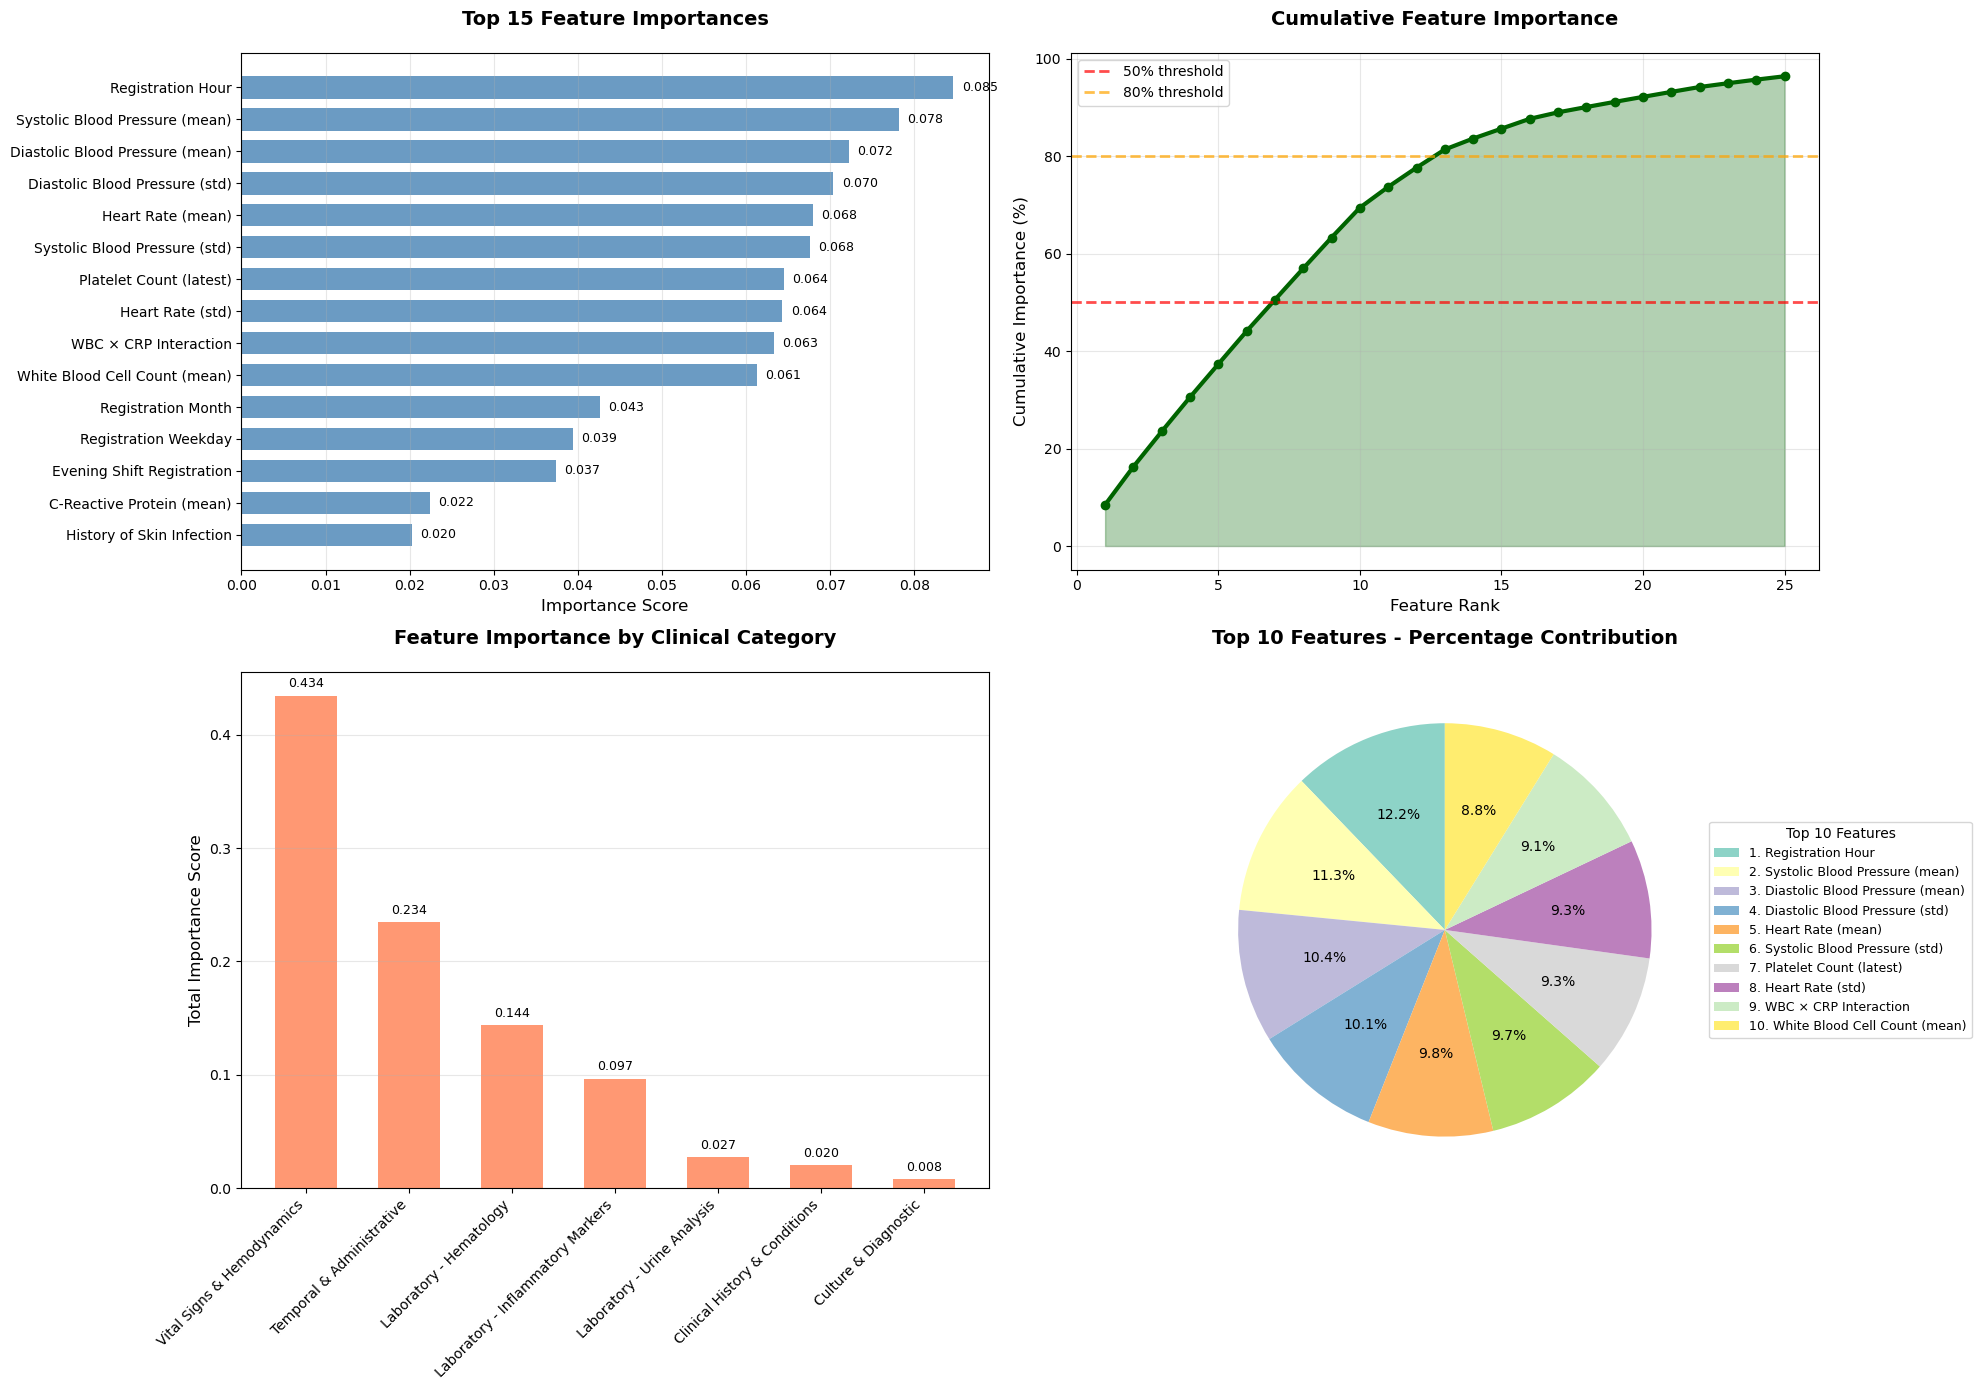


💡 KEY INSIGHTS:
----------------------------------------
• Total features analyzed: 41
• Top 5 features explain: 37.3% of model decisions
• Top 10 features explain: 69.4% of model decisions
• Most important predictor: 'Registration Hour'
• 25th most important: 'Urine Nitrite Score (mean)'

💾 CLEAN FEATURE TABLE STORED:
----------------------------------------
Variable: 'clean_importance_table'
Columns: rank, clean_name, technical_name, importance_score, importance_percentage, cumulative_percentage


In [79]:
# Random Forest Feature Importance with Clean, Human-Readable Variable Names

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def create_feature_name_mapping():
    """
    Create a comprehensive mapping from technical variable names to clean, human-readable names
    """
    name_mapping = {
        # Temporal features
        'reg_hour': 'Registration Hour',
        'reg_month': 'Registration Month',
        'reg_weekday': 'Registration Weekday',
        'reg_shift_Evening': 'Evening Shift Registration',
        'reg_shift_Day': 'Day Shift Registration',
        'reg_shift_Night': 'Night Shift Registration',
        'time_to_culture': 'Time to Culture (hours)',
        
        # Vital signs - Blood Pressure
        'sbp_mean': 'Systolic Blood Pressure (mean)',
        'sbp_std': 'Systolic Blood Pressure (std)',
        'dbp_mean': 'Diastolic Blood Pressure (mean)',
        'dbp_std': 'Diastolic Blood Pressure (std)',
        
        # Vital signs - Heart Rate
        'heart_rate_mean': 'Heart Rate (mean)',
        'heart_rate_std': 'Heart Rate (std)',
        
        # Laboratory - White Blood Cell
        'wbc_mean': 'White Blood Cell Count (mean)',
        'wbc_std': 'White Blood Cell Count (std)',
        'wbc_latest': 'White Blood Cell Count (latest)',
        'wbc_high': 'Elevated White Blood Cell Count',
        'wbc_crp_interaction': 'WBC × CRP Interaction',
        
        # Laboratory - C-Reactive Protein
        'crp_mean': 'C-Reactive Protein (mean)',
        'crp_std': 'C-Reactive Protein (std)',
        'crp_latest': 'C-Reactive Protein (latest)',
        
        # Laboratory - Platelet
        'platelet_mean': 'Platelet Count (mean)',
        'platelet_std': 'Platelet Count (std)',
        'platelet_latest': 'Platelet Count (latest)',
        
        # Laboratory - ESR
        'esr_mean': 'Erythrocyte Sedimentation Rate (mean)',
        'esr_std': 'Erythrocyte Sedimentation Rate (std)',
        'esr_latest': 'Erythrocyte Sedimentation Rate (latest)',
        
        # Laboratory - ANC
        'anc_mean': 'Absolute Neutrophil Count (mean)',
        'anc_std': 'Absolute Neutrophil Count (std)',
        'anc_latest': 'Absolute Neutrophil Count (latest)',
        
        # Urine Analysis
        'urine_wbc_mean': 'Urine White Blood Cell Count (mean)',
        'urine_wbc_std': 'Urine White Blood Cell Count (std)',
        'urine_clarity_mean': 'Urine Clarity Score (mean)',
        'urine_leukocyte_mean': 'Urine Leukocyte Score (mean)',
        'urine_nitrite_mean': 'Urine Nitrite Score (mean)',
        'urine_bacteria_mean': 'Urine Bacteria Score (mean)',
        
        # Clinical Conditions - Binary Indicators
        'has_skin_infection': 'History of Skin Infection',
        'has_uti': 'History of Urinary Tract Infection',
        'has_pneumonia': 'History of Pneumonia',
        'has_sepsis': 'History of Sepsis',
        'has_cellulitis': 'History of Cellulitis',
        'has_abscess': 'History of Abscess',
        'has_bacteremia': 'History of Bacteremia',
        'has_meningitis': 'History of Meningitis',
        'has_endocarditis': 'History of Endocarditis',
        'has_osteomyelitis': 'History of Osteomyelitis',
        'has_hypotension': 'Presence of Hypotension',
        'has_fever': 'Presence of Fever',
        'has_tachycardia': 'Presence of Tachycardia',
        'has_leukocytosis': 'Presence of Leukocytosis',
        
        # Blood Culture
        'blood_culture_before_antibiotic': 'Blood Culture Before Antibiotic',
        'blood_culture_positive': 'Positive Blood Culture',
        
        # Demographics
        'age': 'Patient Age',
        'gender_male': 'Male Gender',
        'gender_female': 'Female Gender',
        
        # Other clinical indicators
        'antibiotic_before_culture': 'Antibiotic Before Culture',
        'culture_time': 'Culture Collection Time',
        'hospital_length_stay': 'Hospital Length of Stay',
        'icu_admission': 'ICU Admission',
        'mortality': 'In-Hospital Mortality'
    }
    
    return name_mapping

def create_clean_feature_importance_table(model, feature_names, top_n=25):
    """
    Create feature importance table with clean, human-readable names
    """
    # Get the name mapping
    name_mapping = create_feature_name_mapping()
    
    # Extract feature importances
    feature_importances = model.feature_importances_
    
    # Create comprehensive feature importance dataframe
    importance_df = pd.DataFrame({
        'technical_name': feature_names,
        'importance_score': feature_importances
    })
    
    # Map to clean names
    importance_df['clean_name'] = importance_df['technical_name'].map(name_mapping)
    
    # Fill missing mappings with formatted technical names
    importance_df['clean_name'] = importance_df['clean_name'].fillna(
        importance_df['technical_name'].str.replace('_', ' ').str.title()
    )
    
    # Calculate percentages
    importance_df['importance_percentage'] = (importance_df['importance_score'] / 
                                            importance_df['importance_score'].sum()) * 100
    
    # Sort by importance (descending)
    importance_df = importance_df.sort_values('importance_score', ascending=False).reset_index(drop=True)
    
    # Add ranking and cumulative percentage
    importance_df['rank'] = range(1, len(importance_df) + 1)
    importance_df['cumulative_percentage'] = importance_df['importance_percentage'].cumsum()
    
    # Reorder columns for better readability
    importance_df = importance_df[['rank', 'clean_name', 'technical_name', 'importance_score', 
                                 'importance_percentage', 'cumulative_percentage']]
    
    return importance_df.head(top_n)

def categorize_clean_features(importance_df):
    """
    Categorize features based on clean names for better analysis
    """
    categories = {
        'Vital Signs & Hemodynamics': [],
        'Laboratory - Hematology': [],
        'Laboratory - Inflammatory Markers': [],
        'Laboratory - Urine Analysis': [],
        'Clinical History & Conditions': [],
        'Temporal & Administrative': [],
        'Culture & Diagnostic': [],
        'Demographics': []
    }
    
    for _, row in importance_df.iterrows():
        clean_name = row['clean_name'].lower()
        
        # Categorize based on clean names
        if any(word in clean_name for word in ['blood pressure', 'heart rate', 'hypotension', 'tachycardia']):
            categories['Vital Signs & Hemodynamics'].append(row)
        elif any(word in clean_name for word in ['white blood cell', 'platelet', 'neutrophil', 'leukocytosis']):
            categories['Laboratory - Hematology'].append(row)
        elif any(word in clean_name for word in ['c-reactive protein', 'erythrocyte sedimentation', 'wbc × crp']):
            categories['Laboratory - Inflammatory Markers'].append(row)
        elif 'urine' in clean_name:
            categories['Laboratory - Urine Analysis'].append(row)
        elif any(word in clean_name for word in ['history', 'infection', 'sepsis', 'pneumonia', 'fever']):
            categories['Clinical History & Conditions'].append(row)
        elif any(word in clean_name for word in ['registration', 'shift', 'time', 'hour', 'month', 'weekday']):
            categories['Temporal & Administrative'].append(row)
        elif any(word in clean_name for word in ['culture', 'antibiotic']):
            categories['Culture & Diagnostic'].append(row)
        elif any(word in clean_name for word in ['age', 'gender', 'male', 'female']):
            categories['Demographics'].append(row)
        else:
            # Add to the most appropriate category or create 'Other'
            if 'Other' not in categories:
                categories['Other'] = []
            categories['Other'].append(row)
    
    # Remove empty categories
    categories = {k: v for k, v in categories.items() if v}
    return categories

# Generate clean feature importance table
print("🔍 RANDOM FOREST FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# Create clean feature importance table
feature_names_list = list(X_features.columns)
clean_importance_table = create_clean_feature_importance_table(rf, feature_names_list, top_n=25)

# Display the clean table (without technical names for cleaner view)
display_table = clean_importance_table[['rank', 'clean_name', 'importance_score', 
                                       'importance_percentage', 'cumulative_percentage']].copy()
display_table.columns = ['Rank', 'Feature Name', 'Importance Score', 'Importance %', 'Cumulative %']

print("\n📋 TOP 25 MOST IMPORTANT FEATURES:")
print("-" * 80)
print(display_table.to_string(index=False, float_format='%.4f'))

# Categorize features
feature_categories = categorize_clean_features(clean_importance_table)

print(f"\n🏷️  FEATURE CATEGORIES:")
print("-" * 50)
for category, features in feature_categories.items():
    print(f"{category}: {len(features)} features")

# Category analysis
category_stats = []
for category, features in feature_categories.items():
    if features:
        importance_scores = [f['importance_score'] for f in features]
        category_stats.append({
            'Category': category,
            'Feature Count': len(features),
            'Total Importance': sum(importance_scores),
            'Average Importance': np.mean(importance_scores),
            'Top Feature': features[0]['clean_name'],
            'Top Feature Rank': features[0]['rank']
        })

category_df = pd.DataFrame(category_stats).sort_values('Total Importance', ascending=False)

print(f"\n📈 CATEGORY-WISE ANALYSIS:")
print("-" * 80)
print(category_df.to_string(index=False, float_format='%.4f'))

# Enhanced visualization with clean names
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# Plot 1: Top 15 Feature Importances with Clean Names
top_15_clean = clean_importance_table.head(15)
y_positions = range(len(top_15_clean))

bars = axes[0, 0].barh(y_positions, top_15_clean['importance_score'], 
                       color='steelblue', alpha=0.8, height=0.7)

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, top_15_clean['importance_score'])):
    axes[0, 0].text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                    f'{score:.3f}', va='center', fontsize=9)

axes[0, 0].set_yticks(y_positions)
axes[0, 0].set_yticklabels(top_15_clean['clean_name'], fontsize=10)
axes[0, 0].set_xlabel('Importance Score', fontsize=12)
axes[0, 0].set_title('Top 15 Feature Importances', 
                     fontsize=14, fontweight='bold', pad=20)
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# Plot 2: Cumulative Importance with better formatting
axes[0, 1].plot(range(1, len(clean_importance_table) + 1), 
                clean_importance_table['cumulative_percentage'], 
                marker='o', linewidth=3, markersize=6, color='darkgreen')
axes[0, 1].axhline(y=50, color='red', linestyle='--', alpha=0.7, linewidth=2, label='50% threshold')
axes[0, 1].axhline(y=80, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='80% threshold')
axes[0, 1].fill_between(range(1, len(clean_importance_table) + 1), 
                        clean_importance_table['cumulative_percentage'], 
                        alpha=0.3, color='darkgreen')
axes[0, 1].set_xlabel('Feature Rank', fontsize=12)
axes[0, 1].set_ylabel('Cumulative Importance (%)', fontsize=12)
axes[0, 1].set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold', pad=20)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Category-wise Analysis
if not category_df.empty:
    bars = axes[1, 0].bar(range(len(category_df)), category_df['Total Importance'], 
                          color='coral', alpha=0.8, width=0.6)
    
    # Add value labels on bars
    for bar, value in zip(bars, category_df['Total Importance']):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                        f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    axes[1, 0].set_xticks(range(len(category_df)))
    axes[1, 0].set_xticklabels(category_df['Category'], rotation=45, ha='right', fontsize=10)
    axes[1, 0].set_ylabel('Total Importance Score', fontsize=12)
    axes[1, 0].set_title('Feature Importance by Clinical Category', fontsize=14, fontweight='bold', pad=20)
    axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Top 10 features with percentage contribution
top_10_clean = clean_importance_table.head(10)
colors = plt.cm.Set3(np.linspace(0, 1, len(top_10_clean)))

wedges, texts, autotexts = axes[1, 1].pie(top_10_clean['importance_percentage'], 
                                          labels=None, autopct='%1.1f%%',
                                          colors=colors, startangle=90)

# Create legend with clean names
legend_labels = [f"{row['rank']}. {row['clean_name']}" for _, row in top_10_clean.iterrows()]
axes[1, 1].legend(wedges, legend_labels, title="Top 10 Features", 
                  loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)
axes[1, 1].set_title('Top 10 Features - Percentage Contribution', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Key insights with clean names
top_feature_clean = clean_importance_table.iloc[0]['clean_name']
least_feature_clean = clean_importance_table.iloc[-1]['clean_name']

print(f"\n💡 KEY INSIGHTS:")
print("-" * 40)
print(f"• Total features analyzed: {len(feature_names_list)}")
print(f"• Top 5 features explain: {clean_importance_table.head(5)['cumulative_percentage'].iloc[-1]:.1f}% of model decisions")
print(f"• Top 10 features explain: {clean_importance_table.head(10)['cumulative_percentage'].iloc[-1]:.1f}% of model decisions")
print(f"• Most important predictor: '{top_feature_clean}'")
print(f"• 25th most important: '{least_feature_clean}'")

# Store clean table for further use
print(f"\n💾 CLEAN FEATURE TABLE STORED:")
print("-" * 40)
print("Variable: 'clean_importance_table'")
print("Columns: rank, clean_name, technical_name, importance_score, importance_percentage, cumulative_percentage")